In [383]:
import numpy as np 
import pandas as pd
import datetime # para convertir a dia de la semana
import calendar # idem

# plots
import matplotlib.pyplot as plt
import seaborn as sns      
%matplotlib inline

from mpl_toolkits.basemap import Basemap

# https://github.com/idontdomath/datos-exploratory-data-analysis/blob/master/class01/03-intro-pandas-flight-delays.ipynb

In [384]:
# estatus = pd.read_csv('status.csv', sep='\t', iterator=True, chunksize=1000)
#cada vez que se corre son los proximos 500
# estatus.get_chunk(500)

In [385]:
trips = pd.read_csv('trip.csv', low_memory=False)
#Se convierte los dates a datetime64[ns].
trips['start_date'] = pd.to_datetime(trips['start_date'])
trips['end_date'] = pd.to_datetime(trips['end_date'])

In [386]:
#Se agrega una nueva columna date que coincide con weather.
trips['date'] = trips['start_date'].apply(lambda x: x.date())
#Se convierte date a datetime64[ns].
trips['date'] = pd.to_datetime(trips['date'])

In [387]:
# chequeo tipos
trips.dtypes

id                             int64
duration                       int64
start_date            datetime64[ns]
start_station_name            object
start_station_id               int64
end_date              datetime64[ns]
end_station_name              object
end_station_id                 int64
bike_id                        int64
subscription_type             object
zip_code                      object
date                  datetime64[ns]
dtype: object

In [388]:
# ejemplo del uso de datetime con día actual
dia_actual = datetime.datetime.today()
dia_actual

datetime.datetime(2017, 4, 14, 2, 38, 2, 827511)

In [389]:
# lo paso a dia de la semana
dia_actual.weekday()

4

In [390]:
# mejor en palabras que en números
calendar.day_name[dia_actual.weekday()]

'Friday'

In [391]:
# función para convertir fecha a día de la semana.
def fecha_a_dia(fecha):
    return calendar.day_name[fecha.weekday()]

In [392]:
#Se crean columnas con los dias de la semana.
trips['start_day_of_week'] = trips['start_date'].map(fecha_a_dia)
trips['end_day_of_week'] = trips['end_date'].map(fecha_a_dia)

In [393]:
trips['horario_inicial'] = trips['start_date'].dt.time
trips['horario_inicial_float'] = trips['start_date'].dt.hour + trips['start_date'].dt.minute / 100
#por el momento dejo ambos por si se necesitan

In [394]:
trips['horario_final'] = trips['end_date'].dt.time
trips['horario_final_float'] = trips['end_date'].dt.hour + trips['end_date'].dt.minute / 100
#idem

In [395]:
trips['duracion_viaje'] = trips['end_date'] - trips['start_date']
# trips['duracion_viaje'] = pd.to_datetime(trips['duracion_viaje'])
# no es necesario pero lo dejo por las dudas, puede servir

In [396]:
# vista final de cómo quedó el dataframe
trips.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,date,start_day_of_week,end_day_of_week,horario_inicial,horario_inicial_float,horario_final,horario_final_float,duracion_viaje
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,2013-08-29,Thursday,Thursday,14:13:00,14.13,14:14:00,14.14,00:01:00
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,95138,2013-08-29,Thursday,Thursday,14:42:00,14.42,14:43:00,14.43,00:01:00
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,97214,2013-08-29,Thursday,Thursday,10:16:00,10.16,10:17:00,10.17,00:01:00
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,95060,2013-08-29,Thursday,Thursday,11:29:00,11.29,11:30:00,11.30,00:01:00
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103,2013-08-29,Thursday,Thursday,12:02:00,12.02,12:04:00,12.04,00:02:00


## ¿Viajes de menos de 3 minutos con misma estación de inicio y fin?
Una primera impresión es que hay viajes "ruidosos": duran menos de 3 minutos y las estaciones de inicio y fin
son las mismas. Esto nos dice que el usuario no tomó el viaje por algún motivo. Se van a filtrar esos viajes.

In [397]:
viajes_no_tomados = trips[(trips['duracion_viaje'] <= '00:03:00') & (trips['start_station_id'] == trips['end_station_id'])]
trips = trips[-((trips['duracion_viaje'] <= '00:03:00') & (trips['start_station_id'] == trips['end_station_id']))]
# hay que hacer trips - viajes_no_tomados para que quede lindo pero requiere un comando (isin o algo asi). 
# no me salio bien asi que a lo ultimo lo modifico

In [398]:
viajes_no_tomados.id.count()

2601

In [399]:
viajes_no_tomados.bike_id.value_counts().count()
# cantidad distintas de bicicletas dentro de esos 2601 viajes. Crei que iba a aportar información 
# para lo de las biciletas descompuestas pero no creo que ayude. Hay que analizar si es que varios de esos viajes
# con el mismo id de bicicleta se tomaron bastante pegados entonces si claramente las devolvieron porq estaban rotas

598

Se filtraron unos 2600 viajes. // acá iría la conclusión acerca de posibles bicicletas descompuestas

### Ahora analicemos lo opuesto, que tan largo puede ser un viaje.

In [400]:
trips[(trips['duracion_viaje'] > "08:00:00")]

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,date,start_day_of_week,end_day_of_week,horario_inicial,horario_inicial_float,horario_final,horario_final_float,duracion_viaje
743,4663,52698,2013-08-29 15:34:00,Mountain View City Hall,27,2013-08-30 06:12:00,Park at Olive,38,150,Subscriber,94301,2013-08-29,Thursday,Friday,15:34:00,15.34,06:12:00,6.12,0 days 14:38:00
744,4532,84990,2013-08-29 13:43:00,Market at 4th,76,2013-08-30 13:19:00,Harry Bridges Plaza (Ferry Building),50,460,Customer,94118,2013-08-29,Thursday,Friday,13:43:00,13.43,13:19:00,13.19,0 days 23:36:00
745,4521,85385,2013-08-29 13:37:00,Market at 4th,76,2013-08-30 13:20:00,Harry Bridges Plaza (Ferry Building),50,390,Customer,94118,2013-08-29,Thursday,Friday,13:37:00,13.37,13:20:00,13.20,0 days 23:43:00
746,5069,86102,2013-08-29 21:41:00,Embarcadero at Folsom,51,2013-08-30 21:37:00,Davis at Jackson,42,269,Customer,94111,2013-08-29,Thursday,Friday,21:41:00,21.41,21:37:00,21.37,0 days 23:56:00
747,4505,97713,2013-08-29 13:30:00,Mountain View Caltrain Station,28,2013-08-30 16:38:00,Mountain View City Hall,27,141,Subscriber,94039,2013-08-29,Thursday,Friday,13:30:00,13.30,16:38:00,16.38,1 days 03:08:00
1454,5120,33088,2013-08-30 06:37:00,Steuart at Market,74,2013-08-30 15:49:00,Steuart at Market,74,277,Customer,94510,2013-08-30,Friday,Friday,06:37:00,6.37,15:49:00,15.49,0 days 09:12:00
1455,5113,34449,2013-08-30 02:16:00,Japantown,9,2013-08-30 11:50:00,Japantown,9,52,Customer,95148,2013-08-30,Friday,Friday,02:16:00,2.16,11:50:00,11.50,0 days 09:34:00
1456,5182,36255,2013-08-30 08:42:00,Harry Bridges Plaza (Ferry Building),50,2013-08-30 18:47:00,Harry Bridges Plaza (Ferry Building),50,350,Customer,94707,2013-08-30,Friday,Friday,08:42:00,8.42,18:47:00,18.47,0 days 10:05:00
1457,6412,70731,2013-08-30 20:04:00,Golden Gate at Polk,59,2013-08-31 15:43:00,Powell at Post (Union Square),71,381,Customer,94028,2013-08-30,Friday,Saturday,20:04:00,20.04,15:43:00,15.43,0 days 19:39:00
1458,6178,70982,2013-08-30 16:59:00,Temporary Transbay Terminal (Howard at Beale),55,2013-08-31 12:42:00,2nd at South Park,64,348,Customer,94107,2013-08-30,Friday,Saturday,16:59:00,16.59,12:42:00,12.42,0 days 19:43:00


## ¿Viajes de más de 8 horas de duración?
Se pueden esperar viajes muy largos de a lo sumo 8 horas de alguien que decidió recorrer varios puntos de la ciudad y aparte en el medio ir parando, pero ya cuando se excede esto hasta casos que incluso superan un día de uso creemos que hubo datos mal cargados o algún otro problema como la incorrecta devolución de la bicicleta. Por eso se van a filtrar esos viajes.

In [401]:
viajes_larguisimos = trips[trips['duracion_viaje'] > "08:00:00"]
trips = trips[-(trips['duracion_viaje'] > "08:00:00")]
# hay que hacer trips - viajes_larguisimos para que quede lindo pero requiere un comando (isin o algo asi). 
# no me salio bien asi que a lo ultimo lo modifico

In [402]:
viajes_larguisimos.id.count()

1884

Se filtraron unos 1884 viajes.

In [403]:
# no es necesario pero lo dejo por las dudas, puede servir
# trips[-((trips['duracion_viaje'] < '1970-01-01 00:10:00') & (trips['start_station_id'] == trips['end_station_id']))]

In [404]:
# ahora los datos quedan más limpios
trips.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,date,start_day_of_week,end_day_of_week,horario_inicial,horario_inicial_float,horario_final,horario_final_float,duracion_viaje
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103,2013-08-29,Thursday,Thursday,12:02:00,12.02,12:04:00,12.04,00:02:00
6,4500,109,2013-08-29 13:25:00,Santa Clara at Almaden,4,2013-08-29 13:27:00,Adobe on Almaden,5,679,Subscriber,95112,2013-08-29,Thursday,Thursday,13:25:00,13.25,13:27:00,13.27,00:02:00
9,4258,114,2013-08-29 11:33:00,San Jose City Hall,10,2013-08-29 11:35:00,MLK Library,11,107,Subscriber,95060,2013-08-29,Thursday,Thursday,11:33:00,11.33,11:35:00,11.35,00:02:00
10,4549,125,2013-08-29 13:52:00,Spear at Folsom,49,2013-08-29 13:55:00,Embarcadero at Bryant,54,368,Subscriber,94109,2013-08-29,Thursday,Thursday,13:52:00,13.52,13:55:00,13.55,00:03:00
11,4498,126,2013-08-29 13:23:00,San Pedro Square,6,2013-08-29 13:25:00,Santa Clara at Almaden,4,26,Subscriber,95112,2013-08-29,Thursday,Thursday,13:23:00,13.23,13:25:00,13.25,00:02:00


# 1) Análisis de viajes según día y horario
### En estos primeros plots se analizará la relación general entre los viajes y el día/horario de la semana.

### ¿El servicio se usa más en la semana o los fines de semana?

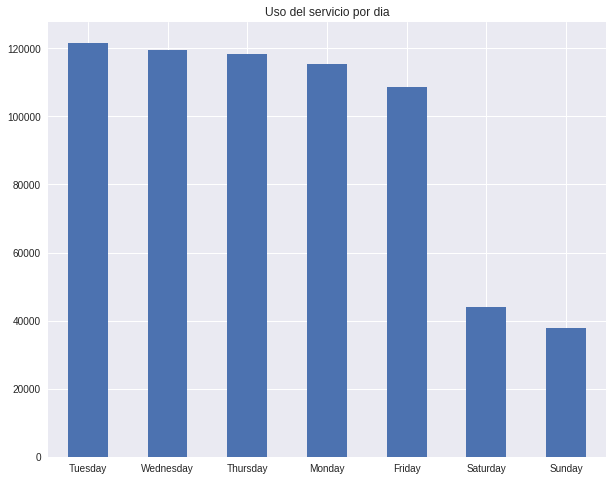

In [405]:
trips['start_day_of_week'].value_counts().plot(kind='bar', rot=0, figsize=(10,8));
plt.title('Uso del servicio por dia');

In [406]:
dias = trips[['start_day_of_week']]
dias_semana = dias[-(dias['start_day_of_week'] == "Saturday")]
dias_semana = dias[-(dias['start_day_of_week'] == "Sunday")]
dias_finde = dias[(dias['start_day_of_week'] == "Saturday") | (dias['start_day_of_week'] == "Sunday")]

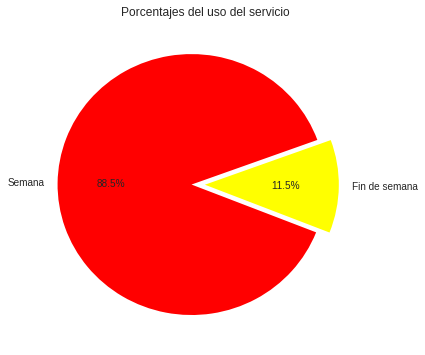

In [407]:
sizes = [dias_semana.start_day_of_week.count(), dias_finde.start_day_of_week.count()]
nombres = ['Semana', 'Fin de semana']

plt.figure(figsize=(6, 6))
plt.title('Porcentajes del uso del servicio')
plt.pie(sizes, labels=nombres, autopct='%1.1f%%', startangle=20, colors=['red', 'yellow'], explode=(0.1, 0))
plt.show()

Se ve que hay una diferencia drástica en el uso del servicio entre la semana y el fin de semana.

### Promedio del uso del servicio por horario:

In [408]:
semana_entera = trips[['start_day_of_week','horario_inicial_float', 'start_station_name', 'end_station_name']].round()
semana_entera['horario_inicial_float'] = semana_entera['horario_inicial_float'].map(lambda x: x if x != 24 else 0)
# 24hs = 0hs
semana_entera.head()

,start_day_of_week,horario_inicial_float,start_station_name,end_station_name
4,Thursday,12.0,South Van Ness at Market,Market at 10th
6,Thursday,13.0,Santa Clara at Almaden,Adobe on Almaden
9,Thursday,11.0,San Jose City Hall,MLK Library
10,Thursday,14.0,Spear at Folsom,Embarcadero at Bryant
11,Thursday,13.0,San Pedro Square,Santa Clara at Almaden


In [409]:
semana = semana_entera[-(semana_entera['start_day_of_week'] == "Saturday")]
semana = semana_entera[-(semana_entera['start_day_of_week'] == "Sunday")]

In [410]:
semana['apariciones'] = semana['start_day_of_week'].map(lambda x: 1) # seteo todas las rows con 1 para despues agrupar
horarios_semana = semana[['horario_inicial_float', 'apariciones']]
semana = semana.drop('apariciones', 1) # vuelvo a dejar el dt como antes
horarios_semana_contador = horarios_semana.groupby('horario_inicial_float').aggregate(sum)

/home/rodrigo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


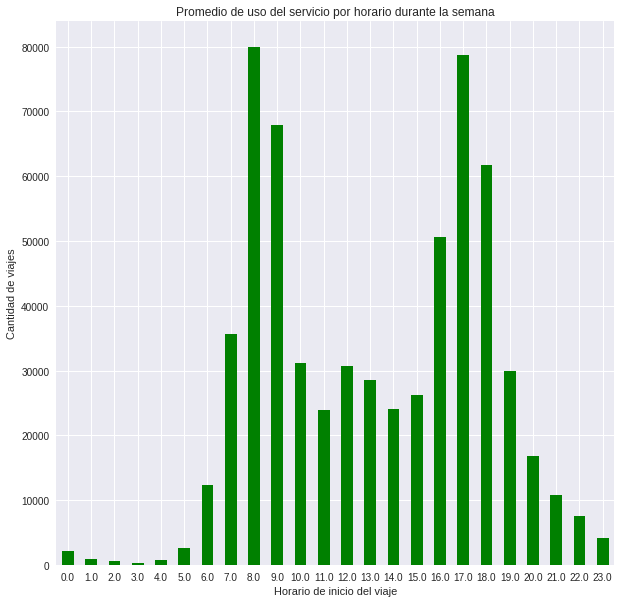

In [411]:
horarios_semana_contador.plot.bar(rot=0, figsize=(10,10), color='green');
plt.ylabel('Cantidad de viajes')
plt.xlabel('Horario de inicio del viaje')
plt.title('Promedio de uso del servicio por horario durante la semana')
plt.legend('')
plt.show()

Se aprecia que durante la semana los horarios pico son de 8 a 9 y de 18 a 19, particularmente cuando la gente va y cuando regresa al trabajo, escuela, etc.

In [412]:
finde = semana_entera[(semana_entera['start_day_of_week'] == "Saturday") | (semana_entera['start_day_of_week'] == "Sunday")]

In [413]:
finde['apariciones'] = finde['start_day_of_week'].map(lambda x: 1) # seteo todas las rows con 1 para despues agrupar
horarios_finde = finde[['horario_inicial_float', 'apariciones']]
finde = finde.drop('apariciones', 1) # vuelvo a dejar el dt como antes
horarios_finde_contador = horarios_finde.groupby('horario_inicial_float').aggregate(sum)

/home/rodrigo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


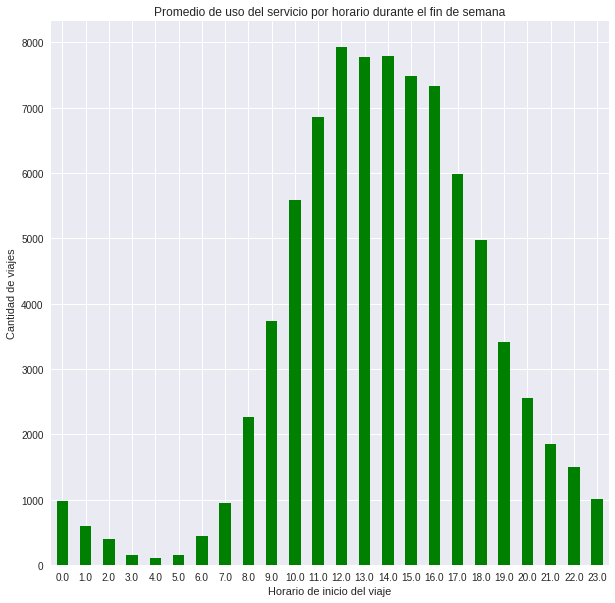

In [414]:
horarios_finde_contador.plot.bar(rot=0, figsize=(10,10), color='green');
plt.ylabel('Cantidad de viajes')
plt.xlabel('Horario de inicio del viaje')
plt.title('Promedio de uso del servicio por horario durante el fin de semana')
plt.legend('')
plt.show()

Los horarios pico los fines de semana son de 11 a 16. También lo que se observa es la disminución del uso del servicio al llegar la noche a pesar de que sea fin de semana. En el siguiente plot se va a analizar esa comparación.

In [415]:
viajes_en_hora_pico_finde = finde[((finde['horario_inicial_float'] >= 11) & (finde['horario_inicial_float'] <= 16))]
viajes_finde_noche = finde[((finde['horario_inicial_float'] >= 20) & (finde['horario_inicial_float'] < 24))]

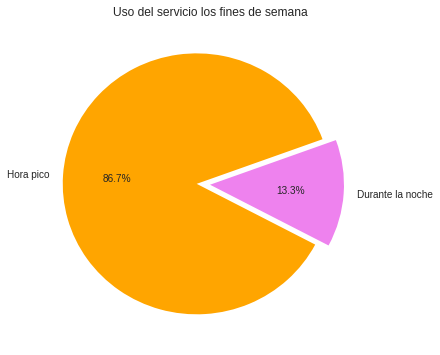

In [416]:
sizes = [viajes_en_hora_pico_finde.start_day_of_week.count(), viajes_finde_noche.start_day_of_week.count()]
nombres = ['Hora pico', 'Durante la noche']

plt.figure(figsize=(6, 6))
plt.title('Uso del servicio los fines de semana')
plt.pie(sizes, labels=nombres, autopct='%1.1f%%', startangle=20, colors=['orange', 'violet'], explode=(0.1, 0))
plt.show()

## A) Análisis de los horarios importantes
### Se analizarán los destinos y trayectos más populares en los horarios críticos de la semana y fin de semana.

In [417]:
viajes_en_hora_pico_semana = semana[((semana['horario_inicial_float'] >= 8) & (semana['horario_inicial_float'] <= 9)) 
                                   | ((semana['horario_inicial_float'] >= 18) & (semana['horario_inicial_float'] <= 19))]

In [418]:
destinos_mas_populares_hora_pico_semana = viajes_en_hora_pico_semana['end_station_name'].value_counts().sort_values(ascending=False)
destinos_mas_populares_hora_pico_semana = destinos_mas_populares_hora_pico_semana.head(10)

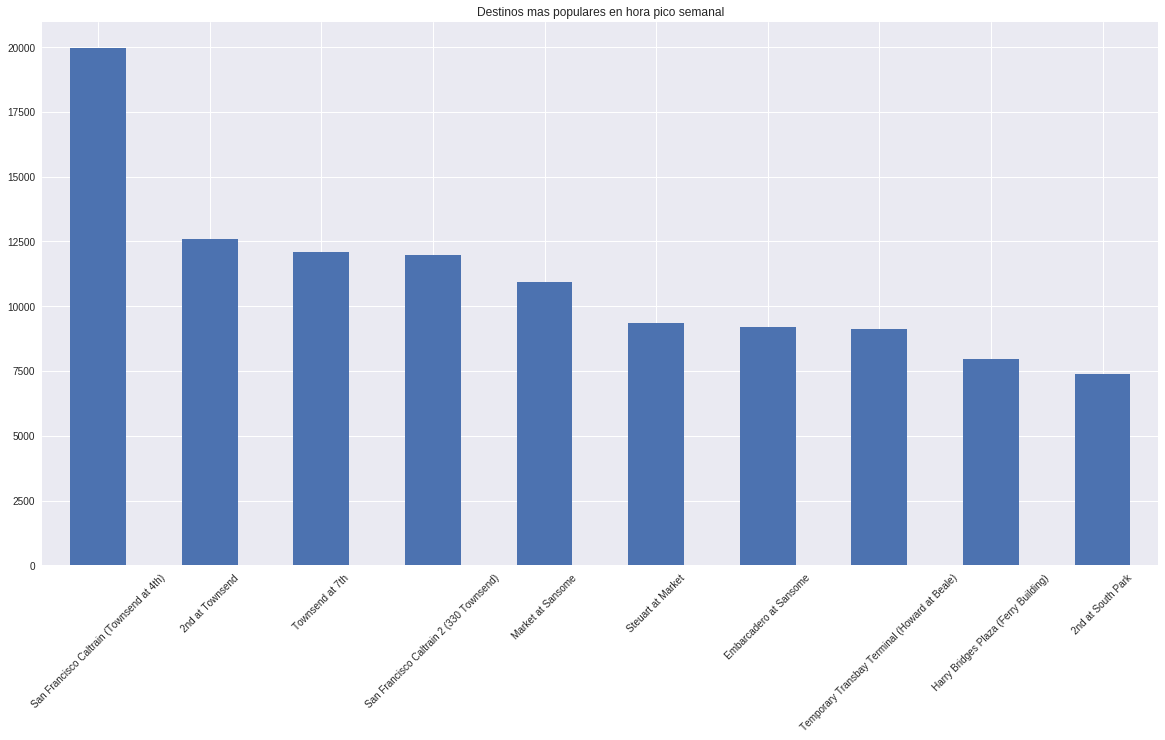

In [419]:
destinos_mas_populares_hora_pico_semana.plot(kind='bar', rot=45, figsize=(20,10));
plt.title('Destinos mas populares en hora pico semanal');

Estos son los 10 destinos más populares durante las horas pico en la semana. En primer lugar se destaca el Caltrain, donde una gran cantidad de gente se dirige luego de trabajar para regresar a sus casas. Las demás estaciones presentan áreas de mucho movimiento de gente: empresas, comercios, etc, y también se encuentra el puerto, por lo que lo más probable es que la gente se dirija allí para concurrir a trabajar.

In [420]:
# función que dado un dataframe con un campo 'start_station_name' y otro 'end_station_name',
# devuelve un diccionario con los start_station como clave y como valor un diccionario con clave el end_station
# y valor la cantidad de viajes de ese trayecto. También devuelve una lista con el trayecto con mayor cantidad
# de viajes junto con el start y end station del mismo. Orden = O(n) siendo n la cantidad de rows del dataframe.
def contador_viajes(dataframe):
    cont_viajes = {}
    viaje_mas_popular = []
    viaje_mas_popular.append(0)
    viaje_mas_popular.append("")
    viaje_mas_popular.append("")
    for index,row in dataframe.iterrows():
        
        if row['start_station_name'] not in cont_viajes:
            cont_viajes[row['start_station_name']] = {}
           
        if row['end_station_name'] not in cont_viajes[row['start_station_name']]:
            cont_viajes[row['start_station_name']][row['end_station_name']] = 1
        else:
            cont_viajes[row['start_station_name']][row['end_station_name']] += 1
        
        if cont_viajes[row['start_station_name']][row['end_station_name']] > viaje_mas_popular[0]:
            viaje_mas_popular[0] = cont_viajes[row['start_station_name']][row['end_station_name']]
            viaje_mas_popular[1] = row['start_station_name']
            viaje_mas_popular[2] = row['end_station_name']
    
    return cont_viajes,viaje_mas_popular

In [421]:
contador_de_viajes_hora_pico_semana,viaje_mas_popular_hora_pico_semana = contador_viajes(viajes_en_hora_pico_semana)
viaje_mas_popular_hora_pico_semana

[3012, 'San Francisco Caltrain 2 (330 Townsend)', 'Townsend at 7th']

Con esto se ve que el viaje más realizado en hora pico durante la semana es el trayecto San Francisco Caltrain 2 (330 Townsend) - Townsend at 7th.

In [422]:
destinos_mas_populares_hora_pico_finde = viajes_en_hora_pico_finde['end_station_name'].value_counts().sort_values(ascending=False)
destinos_mas_populares_hora_pico_finde = destinos_mas_populares_hora_pico_finde.head(10)

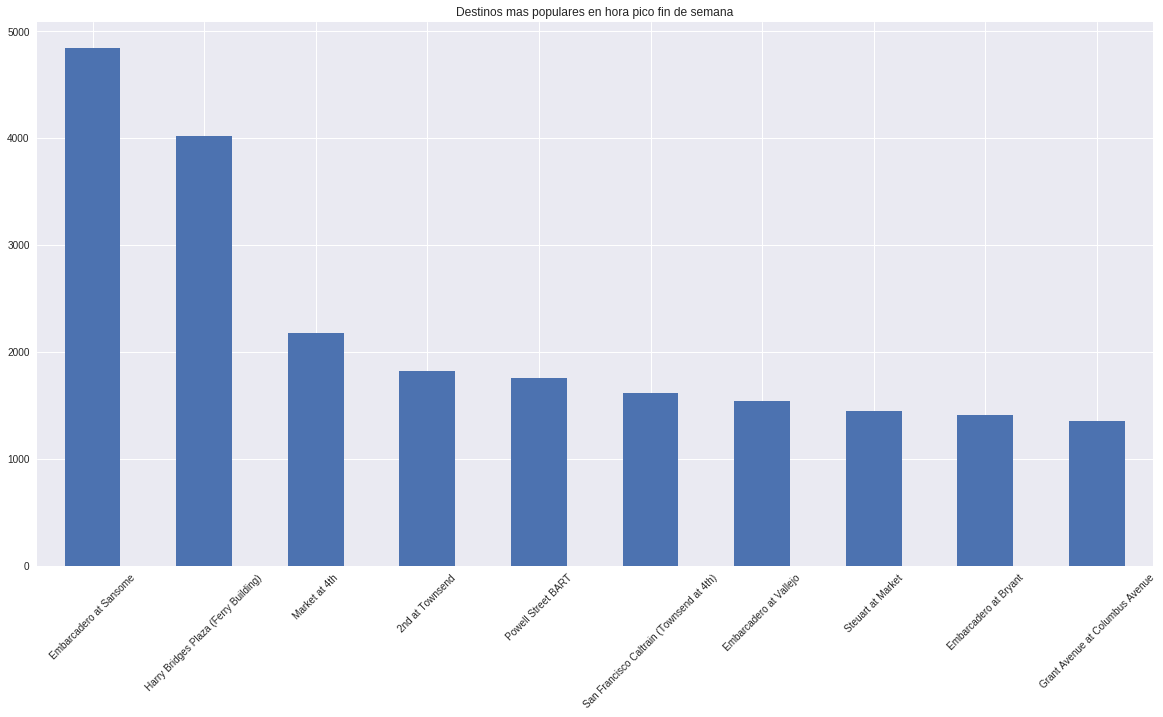

In [423]:
destinos_mas_populares_hora_pico_finde.plot(kind='bar', rot=45, figsize=(20,10));
plt.title('Destinos mas populares en hora pico fin de semana');

Aqui se encuentran los 10 destinos más populares para las horas pico del fin de semana. Se puede apreciar que los mismos se caracterizan por ser lugares muy atractivos para pasear y hacer actividades de ocio.

In [424]:
contador_de_viajes_hora_pico_finde,viaje_mas_popular_hora_pico_finde = contador_viajes(viajes_en_hora_pico_finde)
viaje_mas_popular_hora_pico_finde

[1068, 'Harry Bridges Plaza (Ferry Building)', 'Embarcadero at Sansome']

Con esto se ve que el viaje más realizado en hora pico durante el fin de semana es el trayecto Harry Bridges Plaza (Ferry Building) - Embarcadero at Sansome. Además estos dos son los destinos más concurridos las horas pico de los fines de semana. Un posible uso de esta información podría ser para fines comerciales, ya que esto da la pauta que por esta zona es donde más concentración de gente se encuentra. 

In [425]:
viernes_y_sab = semana_entera[(semana_entera['start_day_of_week'] == "Saturday") | (semana_entera['start_day_of_week'] == "Friday")]
viernes_y_sab_noche = viernes_y_sab[(viernes_y_sab['horario_inicial_float'] >= 20) & (viernes_y_sab['horario_inicial_float'] < 24)]

In [426]:
destinos_mas_populares_viernes_y_sab_noche = viernes_y_sab_noche['end_station_name'].value_counts().sort_values(ascending=False)
destinos_mas_populares_viernes_y_sab_noche = destinos_mas_populares_viernes_y_sab_noche.head(10)

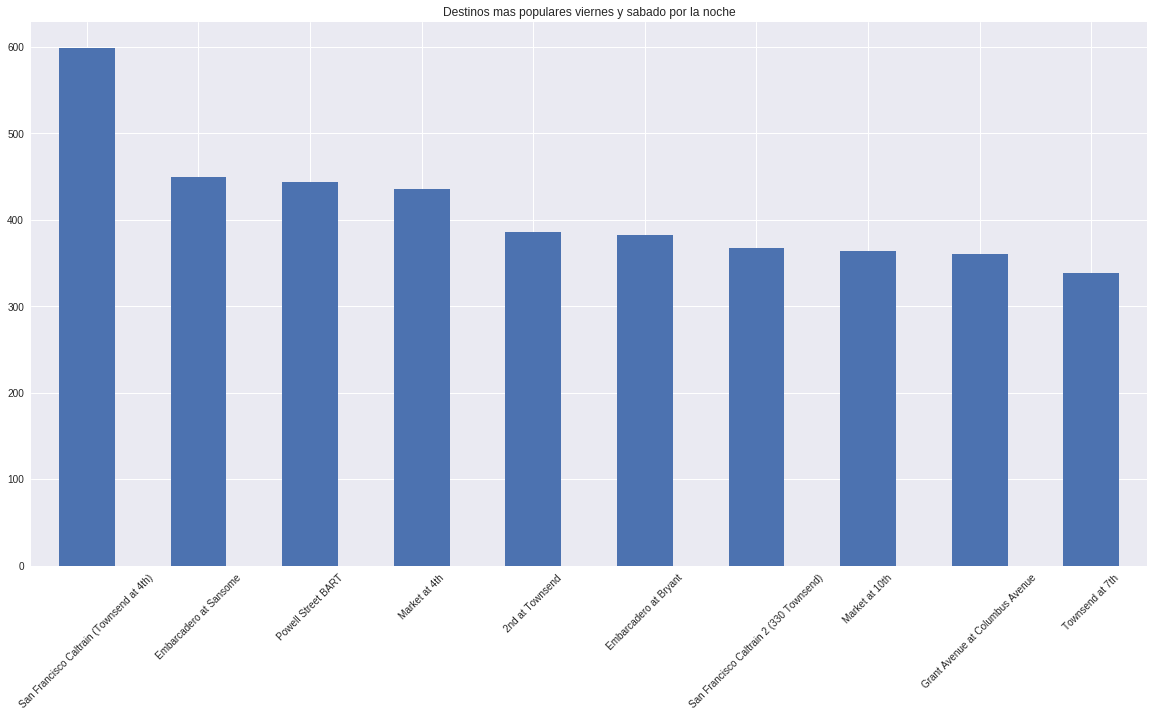

In [427]:
destinos_mas_populares_viernes_y_sab_noche.plot(kind='bar', rot=45, figsize=(20,10));
plt.title('Destinos mas populares viernes y sabado por la noche');

Estos son los destinos más frecuentados los viernes y sábados por la noche. Se analizó aparte del domingo ya que estos son los días que al día siguiente por lo general no se trabaja/concurre a estudiar, por lo que la gente se podría dormir más tarde y planear otro tipo de salida. Se destacan entre los lugares más frecuentados las estaciones Powell Street BART y Market at 4th, las cuales están rodeadas de shoppings, restaurantes y demás.

## B) Análisis relacionado a las duraciones de los viajes
### B.1) - ¿Viajes más largos en la semana o el fin de semana?

In [428]:
semana_entera_con_duracion = trips[['start_day_of_week','horario_inicial_float', 'start_station_name', 'end_station_name','duracion_viaje','duration']].round()
semana_entera_con_duracion.head()

,start_day_of_week,horario_inicial_float,start_station_name,end_station_name,duracion_viaje,duration
4,Thursday,12.0,South Van Ness at Market,Market at 10th,00:02:00,83
6,Thursday,13.0,Santa Clara at Almaden,Adobe on Almaden,00:02:00,109
9,Thursday,11.0,San Jose City Hall,MLK Library,00:02:00,114
10,Thursday,14.0,Spear at Folsom,Embarcadero at Bryant,00:03:00,125
11,Thursday,13.0,San Pedro Square,Santa Clara at Almaden,00:02:00,126


In [429]:
semana_con_duracion = semana_entera_con_duracion[-(semana_entera_con_duracion['start_day_of_week'] == "Saturday")]
semana_con_duracion = semana_entera_con_duracion[-(semana_entera_con_duracion['start_day_of_week'] == "Sunday")]

In [430]:
finde_con_duracion = semana_entera_con_duracion[(semana_entera_con_duracion['start_day_of_week'] == "Saturday") | (semana_entera_con_duracion['start_day_of_week'] == "Sunday")]

In [431]:
semana_con_duracion.duration.mean() / 60 # resultado en minutos

13.467938160917344

In [432]:
finde_con_duracion.duration.mean() / 60 # resultado en minutos

30.593984232967284

Los viajes en promedio duran más los fines de semana. Esto tiene lógica ya que los fines de semana la gente puede usar más tiempo para pasear con la bicileta sin tener un destino en particular cuando durante la semana la gente busca ir al trabajo o lugar donde ejercer sus obligaciones.
Igualmente hay que considerar que esta estadística podría estar dañada por muchos viajes "largos" en el fin de semana, por ejemplo de más de dos horas, que harían subir el promedio general, sin haber tantos viajes con un horario parecido al promedio calculado. A continuación se analizará eso:

In [433]:
semana_con_duracion[semana_con_duracion['duracion_viaje'] > "02:00:00"].start_day_of_week.count()

8250

In [434]:
finde_con_duracion[finde_con_duracion['duracion_viaje'] > "02:00:00"].start_day_of_week.count()

4886

Se observa que tanto en la semana como los fines de semana hay viajes de más de 2 horas, y que ya que la semana tiene más días que el fin de semana y la estadística muestra que son casi el doble de viajes, en promedio esos viajes largos se dan por igual todos los días, por lo que el probema de que haya viajes largos no afecta el resultado de la estadística anterior.

### B.2) - Trayectos interesantes
### A continuación se analizarán los trayectos más frecuentes según un criterio de duración y demás fitros.

In [435]:
finde_viajes_largos = finde_con_duracion[finde_con_duracion['duracion_viaje'] > "00:30:00"]

In [436]:
contador_de_viajes_largos_finde,viaje_largo_mas_popular_finde = contador_viajes(finde_viajes_largos)
viaje_largo_mas_popular_finde

[557,
 'Harry Bridges Plaza (Ferry Building)',
 'Harry Bridges Plaza (Ferry Building)']

Con esto se ve que los viajes mayores a 30 minutos los fines de semana son tanto de inicio como fin la estación Harry Bridges Plaza (Ferry Building). El objetivo de este análisis fue encontrar el trayecto más popular de los fines de semana que sea orientado a pasear (por eso el filtro de la duración). El resultado muestra que el viaje más realizado es empezar en dicha estación, recorrer por más de 30 minutos, y luego volver a esta misma dejar la bicicleta.

In [437]:
harry_harry = finde_viajes_largos[(finde_viajes_largos['start_station_name'] == 'Harry Bridges Plaza (Ferry Building)') & (finde_viajes_largos['end_station_name'] == 'Harry Bridges Plaza (Ferry Building)')]
harry_harry.describe()

,horario_inicial_float,duracion_viaje,duration
count,557.000000,557,557.000000
mean,13.199282,0 days 02:33:30.377019,9207.940754
std,3.028308,0 days 01:45:57.032306,6356.601234
min,5.000000,0 days 00:31:00,1811.000000
25%,11.000000,0 days 01:13:00,4364.000000
50%,13.000000,0 days 01:58:00,7122.000000
75%,15.000000,0 days 03:51:00,13818.000000
max,21.000000,0 days 07:56:00,28549.000000


Como se puede apreciar, estos viajes se caracterizan por su duración promedio de 2 horas y media y que en promedio salen a las 13hs. Esto da la pauta de qué elige la mayoría de gente a la hora de pasear por un largo rato aprovechando el clima de recién entrada la tarde.

In [438]:
semana_viajes_cortos = semana_con_duracion[(semana_con_duracion['duracion_viaje'] > "00:08:00") & (semana_con_duracion['duracion_viaje'] < "00:20:00")]

In [439]:
contador_de_viajes_cortos_semana,viaje_corto_mas_popular_semana = contador_viajes(semana_viajes_cortos)
viaje_corto_mas_popular_semana

[3247, 'Steuart at Market', 'San Francisco Caltrain (Townsend at 4th)']

In [440]:
steuart_caltrain = semana_viajes_cortos[(semana_viajes_cortos['start_station_name'] == 'Steuart at Market') & (semana_viajes_cortos['end_station_name'] == 'San Francisco Caltrain (Townsend at 4th)')]
steuart_caltrain.describe()

,horario_inicial_float,duracion_viaje,duration
count,3247.000000,3247,3247.000000
mean,14.825685,0 days 00:11:38.158299,697.412073
std,3.959800,0 days 00:01:58.426460,116.468743
min,0.000000,0 days 00:09:00,486.000000
25%,14.000000,0 days 00:10:00,615.000000
50%,16.000000,0 days 00:11:00,673.000000
75%,17.000000,0 days 00:13:00,757.000000
max,23.000000,0 days 00:19:00,1182.000000


Con esto se ve que el viaje entre 8 y 20 minutos más popular los días de semana es el trayecto Steuart at Market - San Francisco Caltrain (Townsend at 4th). El objetivo de este análisis fue encontrar el trayecto con una duración normal que más se haga considerando el tráfico que presenta un día semanal. Una posible conclusión debido a la hora promedio de comienzo de los viajes (15hs) es que la gente al terminar de trabajar se dirige desde Steuart at Market (un lugar con mucho movimiento por lo que deducimos que mucha gente trabaja por esa zona) en bicicleta hasta el Caltrain, y toma este transporte para volver a sus casas.

# 2) Análisis de la influencia de ciertas fechas en los viajes

A continuación se estudiará el comportamiento del servicio en fechas particulares. Para eso se hará un plot con los viajes a medida que transcurre el año. Se tomó el 2014 debido a que el 2015 sólo tiene datos hasta agosto.

In [441]:
# funciones para operar con un formato fecha (anio-mes-dia hora:minutos:segundos)
def obtener_dia(fecha):
    return fecha.day
def obtener_mes(fecha):
    return fecha.month
def fecha_sin_hora(fecha):
    return (str(fecha.year) + "-" + str(fecha.month) + "-" + str(fecha.day))

In [442]:
anio_2014 = trips[['start_date','start_day_of_week','horario_inicial_float', 'start_station_name', 'end_station_name','duracion_viaje', 'duration','subscription_type']].round()
anio_2014['horario_inicial_float'] = anio_2014['horario_inicial_float'].map(lambda x: x if x != 24 else 0)
anio_2014 = anio_2014[(anio_2014['start_date'].dt.year) == 2014]
anio_2014['fecha_sin_horario'] = anio_2014['start_date'].map(fecha_sin_hora)
anio_2014['fecha_sin_horario'] = pd.to_datetime(anio_2014['fecha_sin_horario'])
anio_2014['dia'] = anio_2014['start_date'].map(obtener_dia)
anio_2014['mes'] = anio_2014['start_date'].map(obtener_mes)
anio_2014 = anio_2014.sort_values(by='start_date')
anio_2014.head()

,start_date,start_day_of_week,horario_inicial_float,start_station_name,end_station_name,duracion_viaje,duration,subscription_type,fecha_sin_horario,dia,mes
100563,2014-01-01 00:14:00,Wednesday,0.0,San Francisco City Hall,Townsend at 7th,00:07:00,435,Subscriber,2014-01-01,1,1
100564,2014-01-01 00:14:00,Wednesday,0.0,San Francisco City Hall,Townsend at 7th,00:07:00,432,Subscriber,2014-01-01,1,1
100565,2014-01-01 00:17:00,Wednesday,0.0,Embarcadero at Sansome,Beale at Market,00:25:00,1523,Subscriber,2014-01-01,1,1
100566,2014-01-01 00:23:00,Wednesday,0.0,Steuart at Market,Powell Street BART,00:27:00,1620,Customer,2014-01-01,1,1
100567,2014-01-01 00:23:00,Wednesday,0.0,Steuart at Market,Powell Street BART,00:27:00,1617,Customer,2014-01-01,1,1


In [443]:
anio_2014['viaje'] = anio_2014['start_day_of_week'].map(lambda x: 1) # seteo todas las rows con 1 para despues agrupar
viajes_segun_dia = anio_2014[['fecha_sin_horario', 'viaje']]
anio_2014 = anio_2014.drop('viaje', 1) # vuelvo a dejar el dt como antes
viajes_segun_dia_contador = viajes_segun_dia.groupby('fecha_sin_horario').aggregate(sum)
viajes_segun_dia_contador.head()

,viaje
fecha_sin_horario,
2014-01-01,350
2014-01-02,760
2014-01-03,774
2014-01-04,354
2014-01-05,293


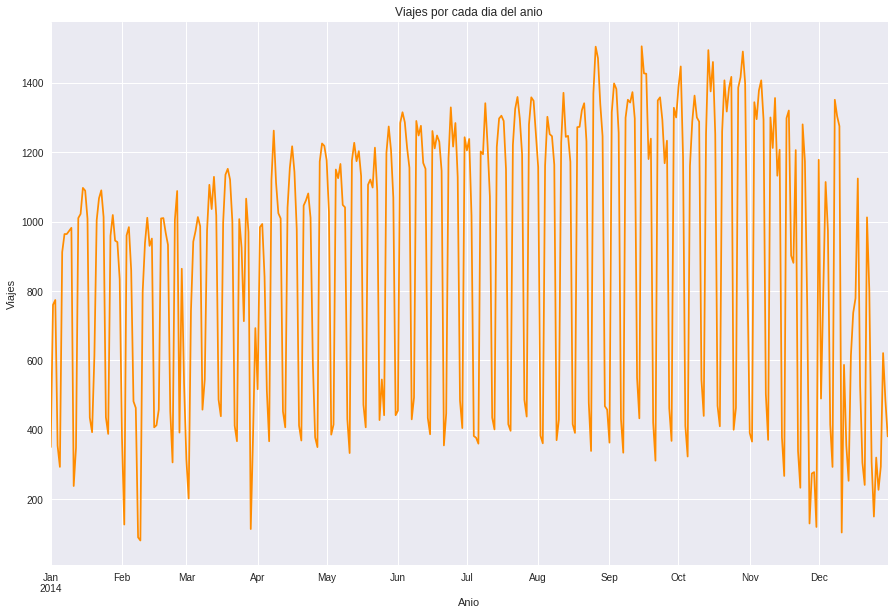

In [444]:
viajes_segun_dia_contador.plot.line(figsize=(15,10), color='darkorange');
plt.xlabel('Anio')
plt.ylabel('Viajes')
plt.title('Viajes por cada dia del anio')
plt.grid(True)
plt.legend('');
plt.show()

En primer lugar se pueden observar picos en fechas como Halloween (fines octubre) y Homecoming (principios octubre). Luego se puede notar como decae el uso del servicio en feriados como por ejemplo en día de acción de gracias (fines noviembre), navidad, semana santa (fines marzo) y demás. También otra observación es la diferencia de viajes que se hacen en inviero en comparación al resto del año. 

In [445]:
viajes_segun_dia_contador[viajes_segun_dia_contador['viaje'] > 1400]

,viaje
fecha_sin_horario,
2014-08-26,1504
2014-08-27,1471
2014-09-15,1505
2014-09-16,1427
2014-09-17,1426
2014-10-02,1447
2014-10-14,1494
2014-10-16,1460
2014-10-21,1407


In [446]:
viajes_segun_dia_contador[viajes_segun_dia_contador['viaje'] < 200]

,viaje
fecha_sin_horario,
2014-02-02,127
2014-02-08,90
2014-02-09,81
2014-03-29,114
2014-11-27,130
2014-11-30,120
2014-12-11,104
2014-12-25,150


## ¿Los días con picos de viajes atraen a clientes no suscriptos al servicio?
Se analizará cuánta gente no suscripta usa el servicio en días festivos como Halloween.

In [447]:
halloween = anio_2014[anio_2014['fecha_sin_horario'] == "2014-10-29"].subscription_type.value_counts()

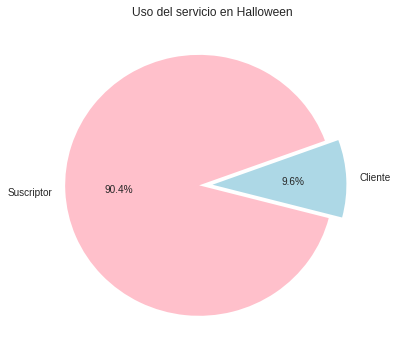

In [448]:
sizes = [haloween.Subscriber, haloween.Customer]
nombres = ['Suscriptor', 'Cliente']

plt.figure(figsize=(6, 6))
plt.title('Uso del servicio en Halloween')
plt.pie(sizes, labels=nombres, autopct='%1.1f%%', startangle=20, colors=['pink', 'lightblue'], explode=(0.1, 0))
plt.show()

En una primera instancia el valor es bajo a pesar de ser Halloween. Ahora se va a buscar como es normalmente la relación Suscriptor-Cliente en porcentajes y también la diferencia en cantidad de viajes para comparar. Tomamos el promedio de un mes el cual se mantenga estable, sin picos, como por ejemplo junio.

In [449]:
junio = anio_2014[anio_2014['mes'] == 6]
suscripciones_junio = junio.subscription_type.value_counts()
dia_promedio_junio = suscripciones_junio / 30

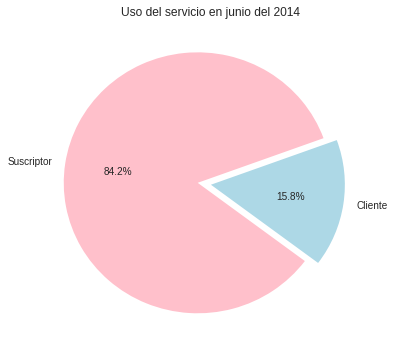

In [450]:
sizes = [dia_promedio_junio.Subscriber, dia_promedio_junio.Customer]
nombres = ['Suscriptor', 'Cliente']

plt.figure(figsize=(6, 6))
plt.title('Uso del servicio en junio del 2014')
plt.pie(sizes, labels=nombres, autopct='%1.1f%%', startangle=20, colors=['pink', 'lightblue'], explode=(0.1, 0))
plt.show()

In [451]:
halloween

Subscriber    1347
Customer       143
Name: subscription_type, dtype: int64

In [452]:
dia_promedio_junio

Subscriber    835.233333
Customer      156.600000
Name: subscription_type, dtype: float64

Se ve que en promedio los días comunes tienen un mayor porcentaje de clientes. Y tampoco influye que en Halloween sean más viajes ya que el aumento sólo se nota en suscriptores y no en clientes. Al contrario de lo que uno esperaría, en Halloween la gente no suscripta al servicio no lo toma en cuenta como una opción.

In [453]:
# estadisticas años:
# año con mas viajes (crece ascendentemente el servicio?)

In [454]:
# cuántas bicicletas hay disponibles para alquilar (está en el finger 1)

# 2) Relación Entre Viajes En Bicicleta y el Clima

In [2]:
trips = pd.read_csv('data/trip.csv', low_memory=False)
weather = pd.read_csv('data/weather.csv', low_memory=False)
#Se convierte los dates a datetime64[ns].
trips['start_date'] = pd.to_datetime(trips['start_date'])
weather['date'] = pd.to_datetime(weather['date'])

In [3]:
#Se agrega una nueva columna date que coincide con weather.
trips['date'] = trips['start_date'].apply(lambda x: x.date())
#Se convierte date a datetime64[ns].
trips['date'] = pd.to_datetime(trips['date'])

In [4]:
#Se convierte zip_code a string en weather para coincidir con trips.
#NOTA: No se convierte zip_code de trips a int64 por un extraño error en to_numeric.
weather['zip_code'] = weather['zip_code'].astype(str)

In [5]:
#Formula para convertir F a C.
def f_to_c(f_temp):
    return round((f_temp - 32) / 1.8, 2)

In [6]:
#Se crean columnas con las temperaturas en C.
weather['max_temperature_c'] = weather['max_temperature_f'].map(f_to_c)
weather['mean_temperature_c'] = weather['mean_temperature_f'].map(f_to_c)
weather['min_temperature_c'] = weather['min_temperature_f'].map(f_to_c)

In [7]:
#Se crean columnas con visibilidad en Km.
weather['max_visibility_km'] = weather['max_visibility_miles'].map(lambda x: x * 1.6)
weather['mean_visibility_km'] = weather['mean_visibility_miles'].map(lambda x: x * 1.6)
weather['min_visibility_km'] = weather['min_visibility_miles'].map(lambda x: x * 1.6)

In [8]:
#Funcion para convertir la duracion de segundos a minutos.
def s_to_m(time):
    return (time / 60)
#Funcion para convertir la duracion de segundos a horas redondeo a 3 decimales.
def s_to_h(time):
    return round((time / 3600),3)

In [9]:
#Se crea una columna con la duracion en minutos y la duracion en horas.
trips['duration_m'] = trips['duration'].map(s_to_m)
trips['duration_h'] = trips['duration'].map(s_to_h)

In [10]:
#Se filtran las duraciones menores o iguales a 3 minutos con la misma estacion de salida y llegada.
trips = trips[-((trips['duration_m'] <= 3.0) & (trips['start_station_id'] == trips['end_station_id']))]

Este filtrado se realiza porque si el viaje duro menos de 3 minutos y termino en la misma estación que comenzó, entonces se puede pensar que hubo un desperfecto técnico en la bicicleta o que el usuario desistió de realizar el viaje, es decir, el viaje no se concreto.

In [11]:
#Se combinan los Dataframes.
joined = trips.merge(weather, left_on=['date', 'zip_code'], right_on=['date', 'zip_code'])

## 2.1) ¿Como se relacionan los viajes en bicicleta y la temperatura?

En esta serie de plots se analizará si hay una correlación entre los viajes en bicicleta y la temperatura.

Como los registros del clima están en forma diurna, es necesario tomar las fechas del viaje sin horarios. Para todos los plots se toma como fecha del viaje a la fecha de inicio del mismo, esto se debe a que es el momento en el cual la persona toma en cuenta las condiciones climáticas para decidir si realizar un viaje o no. 

### 2.1.A) Histograma del Promedio de Temperatura

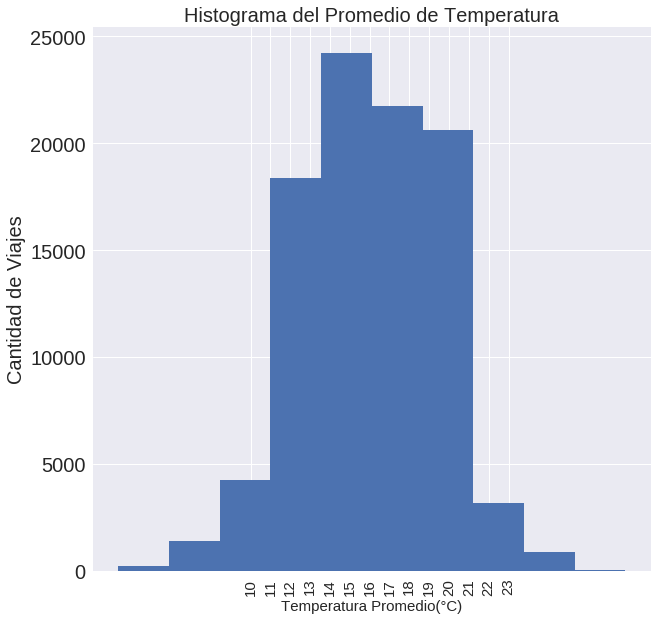

In [264]:
joined.hist(column='mean_temperature_c', grid=True, figsize=(10,10), xrot=90, xlabelsize=15, ylabelsize=20);
plt.xticks(range(10,24,1));
plt.xlabel('Temperatura Promedio(°C)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Histograma del Promedio de Temperatura', fontsize=20);

En este histograma se puede apreciar que la mayor cantidad de los viajes se realizan cuando la temperatura promedio esta entre 12°C y 21°C.  
Si bien puede parecer que la temperatura es algo baja, hay que tener en cuenta que esto es un promedio de la temperatura de todo el día y como San Francisco es una ciudad costera la temperatura suele bajar bastante sobre la noche.

### 2.1.B) Histograma de la Temperatura Máxima

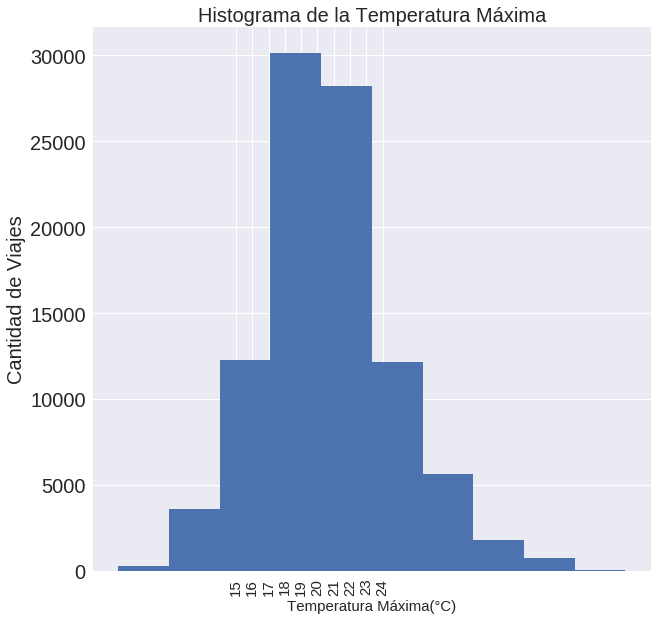

In [263]:
joined.hist(column='max_temperature_c', grid=True, figsize=(10,10), xrot=90, xlabelsize=15, ylabelsize=20);
plt.xticks(range(15,25,1));
plt.xlabel('Temperatura Máxima(°C)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Histograma de la Temperatura Máxima', fontsize=20);

De este histograma se puede obtener que la mayoria de los viajes se realizan cuando la temperatura maxima esta entre 18°C y 23°C.

Si se toman en cuenta los dos histogramas en conjunto, se puede apreciar que la mayoría de las personas buscan temperaturas templadas a la hora de realizar los viajes.  
No es necesario analizar la temperatura mínima, ya que como se dijo antes, la temperatura suele bajar mucho sobre la noche y daría resultados engañosos.

### 2.1.C) Dias con mayor uso simultaneo de Bicicletas y la Temperatura

In [178]:
#Funciones para clasificar.
def f_st(row):
    if row['event'] == 'start_date':
        val = 1
    else:
        val = 0
    return val

def f_en(row):
    if row['event'] == 'end_date':
        val = 1
    else:
        val = 0
    return val

In [179]:
trips_aux = trips[['id', 'start_date', 'end_date', 'zip_code']]
trips_melt = pd.melt(trips_aux, id_vars=['id','zip_code'], value_vars=['start_date', 'end_date'], var_name='event', value_name='time')
trips_melt['time'] = pd.to_datetime(trips_melt['time'])

In [180]:
#Se obtiene la cantidad de bicicletas en uso al mismo tiempo.
trips_ord = trips_melt.sort_values('time', ascending=True) 
trips_ord['start_counter'] = trips_ord.apply(f_st, axis=1)
trips_ord['end_counter'] = trips_ord.apply(f_en, axis=1)
trips_ord['start'] = trips_ord['start_counter'].cumsum()
trips_ord['end'] = trips_ord['end_counter'].cumsum()
trips_ord = trips_ord[['id', 'zip_code', 'time', 'start', 'end']]
trips_ord['in_use'] = trips_ord['start'] - trips_ord['end']
trips_ord = trips_ord.sort_values('in_use', ascending=False)

In [181]:
#Se eliminan los horarios para coincidir con weather.csv.
trips_ord['time'] = trips_ord['time'].apply(lambda x: x.date())
#Se convierte time a datetime64[ns].
trips_ord['time'] = pd.to_datetime(trips_ord['time'])

In [182]:
#Se combinan los Dataframes.
joined_simul = trips_ord.merge(weather, left_on=['time', 'zip_code'], right_on=['date', 'zip_code'])

In [183]:
#Solo hay que quedarse con el maximo de bicicletas simultaneas para ese dia.
joined_max_simul = joined_simul.drop_duplicates(subset=['time'], keep='first')

In [184]:
#Nos quedamos con los 10 valores maximos y las columnas que interesan.
joined_max_simul_bar = joined_max_simul[:10]
joined_max_simul_bar = joined_max_simul_bar[['time', 'mean_temperature_c', 'max_temperature_c']]
joined_max_simul_bar.set_index('time', inplace=True)

En el siguiente gráfico de barras se pueden aprecian los 10 días (de los cuales hay datos de temperatura) con mayor uso simultaneo de bicicletas(ordenados de forma descendente), junto con su temperatura promedio y temperatura máxima. La locación tomada para el clima de cada día, es donde se produce su respectivo pico máximo de bicicletas en uso.

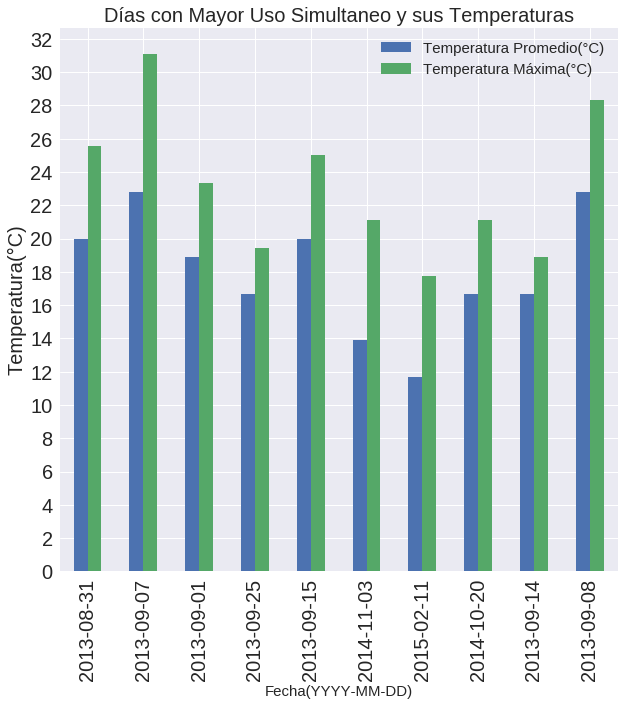

In [260]:
bar = joined_max_simul_bar.plot.bar(figsize=(10,10), fontsize=20);
#Elimina el 00:00:00 del plot.
bar.set_xticklabels(joined_max_simul_bar.index.format());
plt.yticks(range(0,33,2));
plt.xlabel('Fecha(YYYY-MM-DD)', fontsize=15);
plt.ylabel('Temperatura(°C)', fontsize=20);
plt.title('Días con Mayor Uso Simultaneo y sus Temperaturas', fontsize=20);
plt.legend(['Temperatura Promedio(°C)', 'Temperatura Máxima(°C)'], fontsize=15);

Primero es interesante notar que los dos primeros días tienen dos de las mayores temperaturas máximas, 26°C y 31°C respectivamente, pero el ultimo día no tiene la temperatura mas fría, por el contrario tiene una de las temperaturas máximas mas altas, 28°C.  
El segundo punto importante a notar es que la mayoría de estos días tienen temperaturas templadas, es decir, sus temperaturas promedio varían entre 12°C y 23°C mientras que sus temperaturas máximas están entre 18 y 26°C.  
Por ultimo, es evidente que si bien la cantidad de bicicletas en uso simultáneamente decrece a lo largo del gráfico de barras, las temperaturas se mantienen siempre dentro de un mismo rango.

### 2.1.D) Conclusión de Viajes y Temperatura

Usando los plots anteriores se puede concluir que la mayor cantidad de viajes se realizan cuando la temperatura es templada, es decir, cuando esta alrededor de los 25°C.
Para describir este fenómeno hay que tener en cuenta los motivos por los cuales se podría realizar un viaje, para simplificar se tomaran dos casos:
1. En el caso de que se quiera realizar un viaje por la necesidad de trasladarse, la temperatura no afecta mucho, excepto en casos de muy bajas o muy altas temperaturas.
2. El caso en el cual se quiere realizar un viaje por placer es el que interesa, ya que es aquí cuando la temperatura juega un rol importante. Con temperaturas templadas las personas estarán mas predispuestas a realizar viajes en bicicleta, como muestran los plots obtenidos. 

Por ultimo, es importante notar que las mejores temperaturas se suelen presentar sobre la tarde, ya que es cuando comienza a bajar el sol, por eso no seria extraño que la mayor cantidad de los viajes se realicen en horarios de la tarde.

## 2.2) ¿Como se relacionan los viajes y la visibilidad?

En la siguiente serie de plots se tratara de analizar si hay una correlación entre los viajes en bicicletas y la visibilidad.  

Como los registros del clima están en forma diurna, es necesario tomar las fechas del viaje sin horarios. Para todos los plots se toma como fecha del viaje a la fecha de inicio del mismo, esto se debe a que es el momento en el cual la persona toma en cuenta las condiciones climáticas para decidir si realizar un viaje o no. 

### 2.2.A)  Grafico de Barras de Visibilidad Promedio y Histograma de Visibilidad Promedio

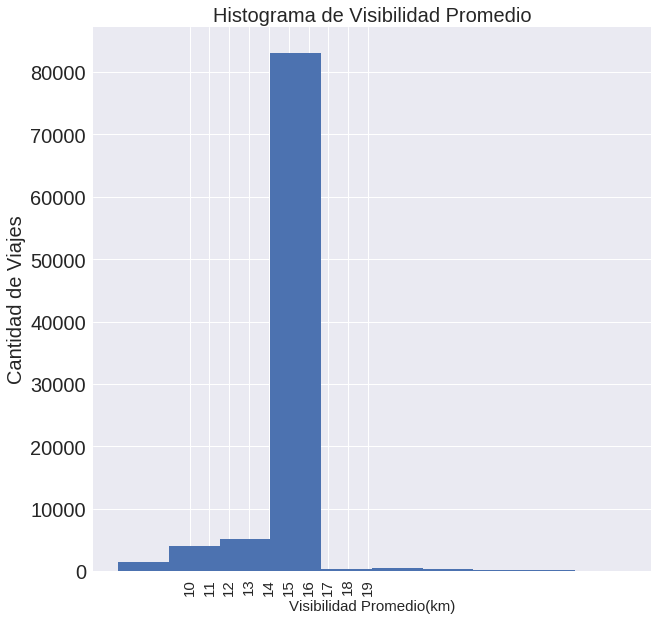

In [266]:
joined.hist(column='mean_visibility_km', grid=True, figsize=(10,10), xrot=90, xlabelsize=15, ylabelsize=20);
plt.xticks(range(10,20,1));
plt.xlabel('Visibilidad Promedio(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Histograma de Visibilidad Promedio', fontsize=20);

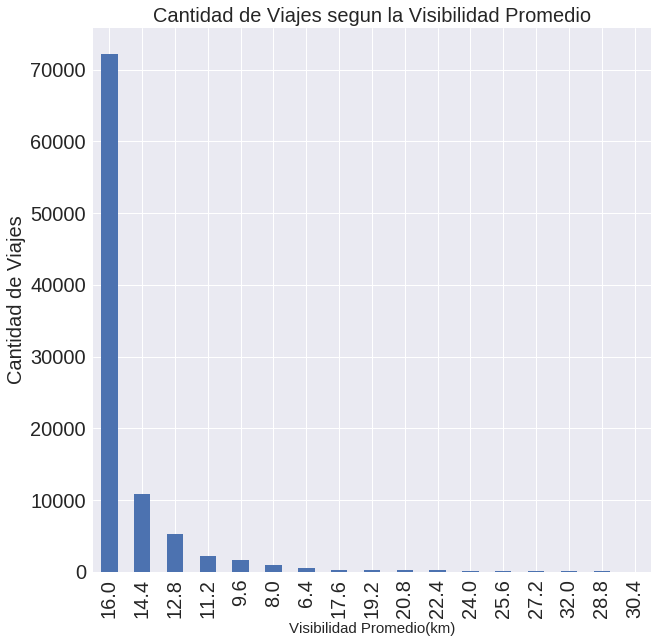

In [283]:
joined['mean_visibility_km'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Visibilidad Promedio(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes segun la Visibilidad Promedio', fontsize=20);

De este plot se pueden extraer tres puntos importantes:  
* La mayoría de los viajes en bicicleta se realizan cuando la visibilidad promedio esta entre 14.4km y 16km, mas precisamente cuando esta en 16km.
* Por encima de los 16km de visibilidad promedio hay escasez de datos, por lo tanto, se puede intuir que no es normal que en San Francisco se presenten visibilidades promedio tan elevadas.  
* Sino se toman en cuenta las visibilidades promedio mayores a 16km(porque no hay datos suficientes), la diferencia entre las visibilidades promedio mayores o iguales a 14.4km y las menores a esta es abismal. Esto no es un dato menor, ya que hay que tener una buena visibilidad al realizar un viaje para que este sea seguro y queda claro, por esta diferencia, que el usuario prioriza mucho la seguridad.

Ahora seria importante analizar que sucede con la visibilidad mínima, ya que por cuestiones de seguridad es importante que haya una buena visibilidad mínima para evitar accidentes.

### 2.2.B) Grafico de Barras de Visibilidad Mínima y Histograma de Visibilidad Mínima

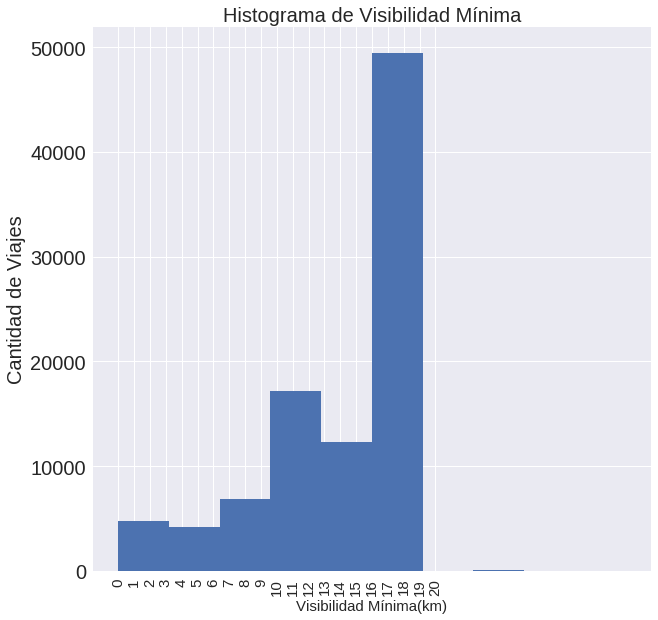

In [270]:
joined.hist(column='min_visibility_km', grid=True, figsize=(10,10), xrot=90, xlabelsize=15, ylabelsize=20);
plt.xticks(range(0,21,1));
plt.xlabel('Visibilidad Mínima(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Histograma de Visibilidad Mínima', fontsize=20);

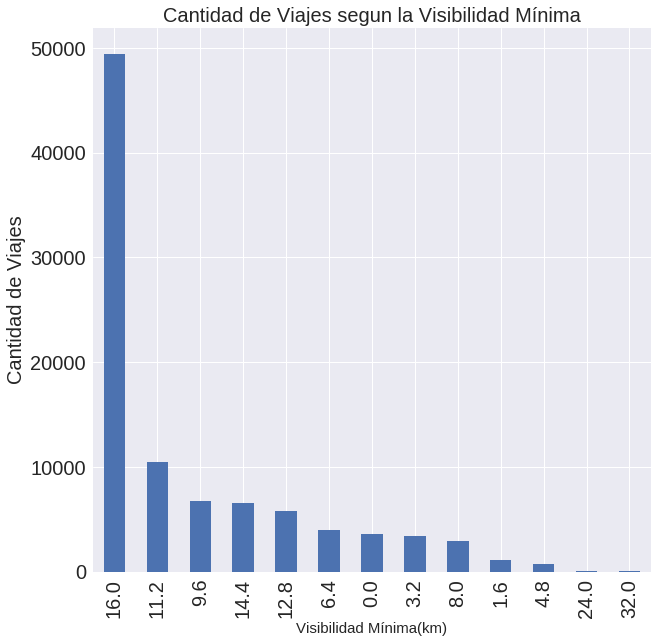

In [284]:
joined['min_visibility_km'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Visibilidad Mínima(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes segun la Visibilidad Mínima', fontsize=20);

En estos dos plots se apreciar de nuevo que la mayor cantidad de viajes se realiza cuando la visibilidad mínima es de 16km. Ademas es importante notar que de nuevo se manifiesta la gran separación entre la visibilidad de 16km y las que son menores a esta. Por ejemplo, si tomamos la visibilidad mínima de 11.2km podemos ver que hay una diferencia aproximada de 40000 viajes con la visibilidad de 16km

### 2.2.C) Grafico de Barras de Visibilidad Máxima

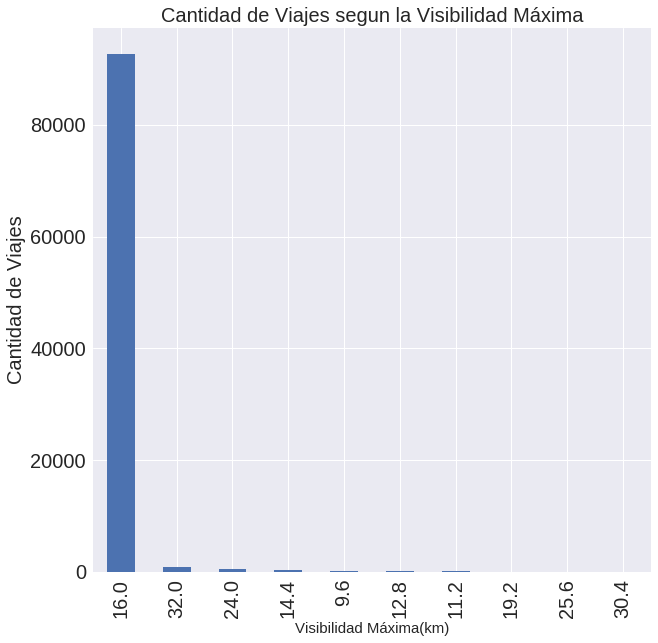

In [285]:
joined['max_visibility_km'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Visibilidad Máxima(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes segun la Visibilidad Máxima', fontsize=20);

De este plot es muy difícil sacar conclusiones ya que la diferencia de la visibilidad máxima de 16km con las demás es demasiado grande. Lo único importante a destacar, es que no hay ningún valor de visibilidad máxima menor a 9.6km, lo cual indicaría que nunca hay visibilidades máximas menores a 9.6km, lo cual es poco probable, o bien que no se realizan viajes cuando la visibilidad máximas son tan bajas.

### 2.D) Dias con mayor uso simultaneo de Bicicletas y la Visibilidad

In [191]:
#Nos quedamos con los 10 valores maximos y las columnas que interesan.
joined_max_simul_vis_bar = joined_max_simul[:10]
joined_max_simul_vis_bar = joined_max_simul_vis_bar[['time', 'mean_visibility_km', 'min_visibility_km', 'max_visibility_km']]
joined_max_simul_vis_bar.set_index('time', inplace=True)

En el siguiente gráfico de barras se pueden aprecian los 10 días (de los cuales hay datos de temperatura) con mayor uso simultaneo de bicicletas(ordenados de forma descendente), junto con su visibilidad promedio, visibilidad mínima y visibilidad máxima. La locación tomada para el clima de cada día, es donde se produce su respectivo pico máximo de bicicletas en uso.

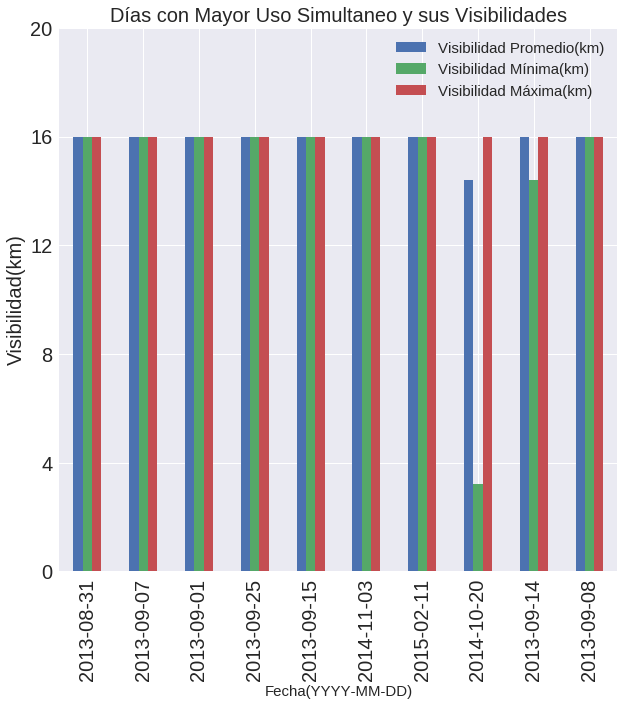

In [298]:
bar = joined_max_simul_vis_bar.plot.bar(figsize=(10,10), fontsize=20);
#Elimina el 00:00:00 del plot.
bar.set_xticklabels(joined_max_simul_vis_bar.index.format());
plt.yticks(range(0,23,4));
plt.xlabel('Fecha(YYYY-MM-DD)', fontsize=15);
plt.ylabel('Visibilidad(km)', fontsize=20);
plt.title('Días con Mayor Uso Simultaneo y sus Visibilidades', fontsize=20);
plt.legend(['Visibilidad Promedio(km)', 'Visibilidad Mínima(km)', 'Visibilidad Máxima(km)'], fontsize=15);

Este plot confirma la tendencia que se había marcado previamente, los 10 dias con mayor uso simultaneo de bicicletas presentan una visibilidad promedio igual o cercana a los 16km. Ademas la mayoría presentan visibilidades mínimas y máximas también de 16km.  
El único caso llamativo es del dia 2014-10-20 en el cual la visibilidad mínima es de 3km, pero si bien su visibilidad mínima es baja su visibilidad máxima y visibilidad promedia se mantienen dentro de lo esperado. Esto nos indicaría que la mayor cantidad de viajes de ese día se habría producido en horarios donde la visibilidad era más cercana a la máxima que a la mínima.

### 2.2.E) Conclusión de Viajes y Visibilidad

Dados los plots vistos se puede concluir claramente que la visibilidad máxima, mínima y mediana deben ser de, o al menos cercano a, 16km para que se produzca un mayor uso del servicio de bicicletas. Esto claramente esta relacionado, como ya se menciono antes, con la seguridad, los usuarios ponen a la seguridad como uno de los puntos más importantes a la hora de decidir si realizar un viaje en bicicleta o no. Por ejemplo, nadie realizaría un viaje bicicleta cuando hay niebla(evento en el cual hay una visibilidad muy baja) porque eso conllevaría un riesgo importante. 

## 2.3) ¿Como se relacionan los viajes y las estaciones climáticas?

### 2.3.A) Cantidad de Viajes y Estaciones Climáticas

En la siguiente serie de plots se analizará si hay una relación entre los viajes en bicicleta y las estaciones climáticas.

In [12]:
#Funcion para clasificar estaciones climaticas.
def estacion(date):
    if date.month >= 3 and date.month <= 5:
        return 'Primavera'
    elif date.month >= 6 and date.month <= 8:
        return 'Verano'
    elif date.month >= 9 and date.month <= 11:
        return 'Otoño'
    else:
        return 'Invierno'

In [15]:
#Se crea la columna con la estacion climatica.
trips['estacion_clima'] = trips['date'].map(estacion)

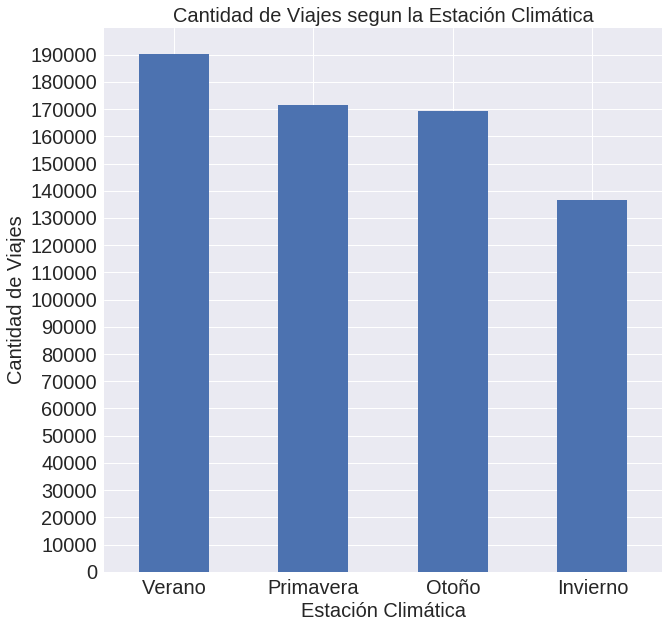

In [19]:
trips['estacion_clima'].value_counts(sort=True).plot.bar(figsize=(10,10), rot=0, fontsize=20);
plt.yticks(range(0,200000,10000))
plt.xlabel('Estación Climática', fontsize=20);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes segun la Estación Climática', fontsize=20);

De este plot podemos observar:  
* La estación climática con la mayor cantidad de viajes es Verano. Esto esta dentro de lo esperado ya que en Verano se llega fácilmente a temperaturas de 25°C.  
* Las siguientes dos estaciones son Primavera y Otoño. Esto de nuevo concuerda con lo dicho previamente, en estas estaciones climáticas hay temperaturas que se acercan a 25°C.  
* Por ultimo, es importante notar que todas las estaciones mantienen un piso de 130000 viajes. Esto va de la mano con lo dicho en la sección 2.1.D y 2.2.E, si alguien quiere utilizar el servicio de bicicletas por un motivo no recreativo, no suele darle demasiada importancia a factores climáticos excepto que conlleven un riesgo para su seguridad.

### 2.3.B) Duración promedio de Viajes y Estaciones Climáticas

En este plot se analizará las duraciones promedio de los viajes en cada estación.

In [20]:
grouped_season = trips[['estacion_clima', 'duration_m']].groupby('estacion_clima')\
.aggregate('mean')

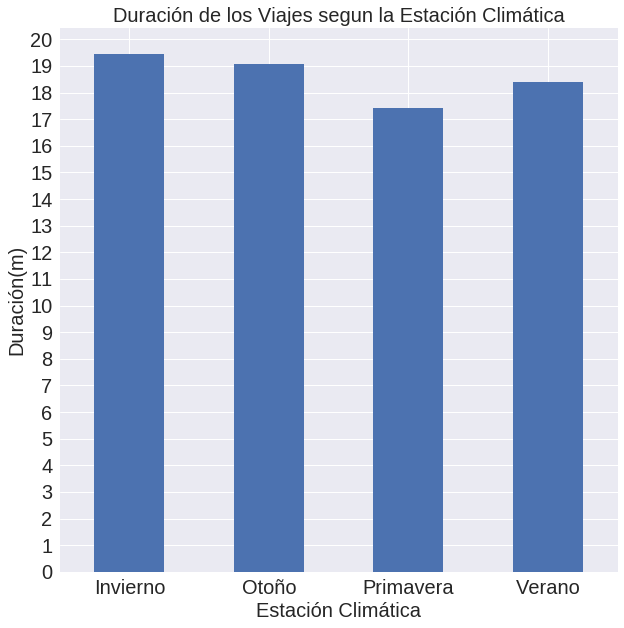

In [24]:
grouped_season.plot.bar(figsize=(10,10), rot=0, fontsize=20);
plt.yticks(range(0,21,1));
plt.xlabel('Estación Climática', fontsize=20);
plt.ylabel('Duración(m)', fontsize=20)
plt.title('Duración de los Viajes segun la Estación Climática', fontsize=20);
plt.legend('');

De este plot podemos hacer tres observaciones importantes:  
* Primero, si bien Invierno es la estación climática con menor cantidad de viajes, es la que tiene la mayor duración promedio.
* Segundo, tanto Verano como Primavera, que son las estaciones climáticas con la mayor cantidad de viajes, tienen las menores duraciones promedio.
* Por ultimo, todas las duraciones promedio se mantienen dentro de un rango bastante pequeño(17m - 19m).

### 2.3.C) Conclusión de Viajes y Estaciones Climáticas

Las conclusiones que se pueden realizar a raíz de los plots a analizados son:  
* Hay una mayor cantidad de viaje en estaciones climáticas donde la temperatura es mas cálida. Ademas la diferencia, en termino de cantidades de viajes, entre Verano e Invierno es bastante grande en favor del Verano.  
* Como se expreso anteriormente, todas las estaciones tienen un piso 130000 viajes. Esto da a entender que una gran parte de los usuarios no pone como prioridad al clima a la hora de realizar un viaje, esto se puede deber a que la mayoría de los usuarios utiliza el servicio de bicicletas como modo de transporte y no como en forma recreativa.

# 2.4) ¿Que sucede con los 5 viajes de mayor duración?

En los siguientes plots se analizara que sucede con la temperatura, visibilidad y estación climática para los 5 viajes con mayor duración. Se utilizan las duraciones menores o iguales a 12 horas porque se considera que un viaje continuado puede durar, como mucho, 12 horas si se permiten interrupciones de duración corta. Ademas se toman solo los viajes que ocurren durante el día para evitar confusiones con bicicletas que olvidaron entregarse.  
Algunos de los motivos por los cuales se pueden realizar viajes largos son, por ejemplo:  
* Realizar un tour de la ciudad de San Francisco.  
* Realizar actividad física intensiva.
* Tener que realizar varios trayectos en horarios diferentes.

In [198]:
#Se obtienen los 5 viajes con mayor duracion (que poseen datos climaticos) menores a 12 horas
#que ocurran durante el dia (se toman solo viajes que comiencen a la mañana).
joined['start_hour'] = joined['start_date'].map(lambda x: x.hour)
top_dur = joined[(joined['start_hour'] >= 7)  & (joined['start_hour'] <= 11) & (joined['duration_h'] <= 12)]
top_dur = top_dur.sort_values('duration_h', ascending=False)[:5]

### 2.4.A) Temperatura de los 5 Viajes con Mayor Duración

In [199]:
top_dur_temp = top_dur[['duration_h', 'max_temperature_c', 'min_temperature_c', 'mean_temperature_c']]
top_dur_temp.set_index('duration_h', inplace=True)

Se muestran los 5 viajes con mayor duración (con sus respectivas duraciones, en horas, como label) ordenados de forma descendente junto con sus respectivas temperaturas máximas, temperaturas mínimas y temperaturas promedio.

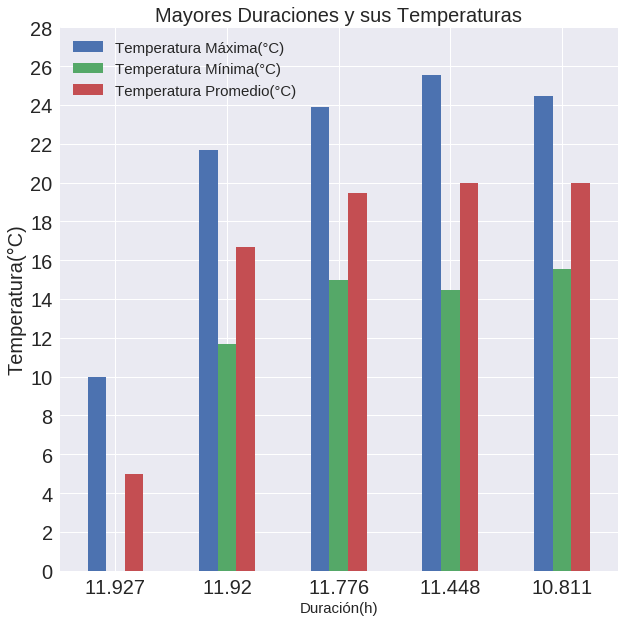

In [301]:
top_dur_temp_bar = top_dur_temp.plot.bar(figsize=(10,10), fontsize=20, rot=0);
plt.yticks(range(0,30,2));
plt.xlabel('Duración(h)', fontsize=15);
plt.ylabel('Temperatura(°C)', fontsize=20);
plt.title('Mayores Duraciones y sus Temperaturas', fontsize=20);
plt.legend(['Temperatura Máxima(°C)', 'Temperatura Mínima(°C)', 'Temperatura Promedio(°C)'], fontsize=15);

De este plot se puede hacer las siguientes observaciones:  
* El viaje con la duración mas larga es también el viaje con las temperaturas mas frías, pero los 4 viajes restantes tienen temperaturas mas cálidas y se ajustan a lo visto en la sección 2.1. Por lo tanto, se puede tomar al primer viaje como una excepción.
* Los 4 viajes con temperaturas cálidas tienen temperaturas muy parecidas.
* Con lo visto en este plot se puede observar que hay una relación entre los viajes de mayor duración y la temperatura, y es que en temperaturas cercanas a los 25°C se producen viajes de mayor duración.

### 2.4.B) Visibilidad de los 5 Viajes con Mayor Duración

In [201]:
top_dur_vis = top_dur[['duration_h', 'max_visibility_km', 'min_visibility_km', 'mean_visibility_km']]
top_dur_vis.set_index('duration_h', inplace=True)

Se muestran los 5 viajes con mayor duración (con sus respectivas duraciones, en horas, como label) ordenados de forma descendente junto con sus respectivas visibilidades máximas, visibilidades mínimas y visibilidades promedio.

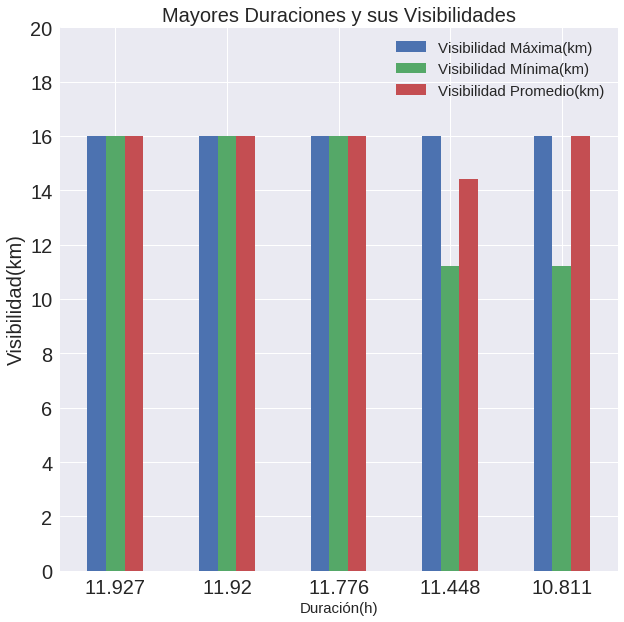

In [305]:
top_dur_vis_bar = top_dur_vis.plot.bar(figsize=(10,10), fontsize=20, rot=0);
plt.yticks(range(0,22,2));
plt.xlabel('Duración(h)', fontsize=15);
plt.ylabel('Visibilidad(km)', fontsize=20);
plt.title('Mayores Duraciones y sus Visibilidades', fontsize=20);
plt.legend(['Visibilidad Máxima(km)', 'Visibilidad Mínima(km)', 'Visibilidad Promedio(km)'], fontsize=15);

En este plot se puede observar que:  
* Todas las visibilidades promedio y visibilidades máximas son iguales o muy cercanas a 16km.  
* Si bien 2 de los 5 viajes tienen visibilidad mínimas menores a 16km nunca llegan a ser menores a 10km.  
* Por lo observado se puede concluir que para que se produzcan viajes de esta duración la visibilidad debe ser muy buena, esto esta acorde con lo dicho en la sección 2.2.
 

### 2.4.C) Estación Climática de los 5 Viajes con Mayor Duracíon

In [203]:
#Se muestran las duracion(en horas) y su respectiva estacion.
top_dur[['duration_h', 'estacion_clima']]

,duration_h,estacion_clima
11085,11.927,Invierno
57906,11.920,Primavera
48689,11.776,Verano
29296,11.448,Verano
46007,10.811,Verano


Las estaciones climáticas de los viajes de mayor duración, ordenados de mayor a menor, son:  
**1.** Invierno  
**2.** Primavera  
**3.** Verano  
**4.** Verano  
**5.** Verano  

Dados estos datos se puede decir que:  
* La mayor duración de los 5 viajes se produce en Invierno y la menor duración de los 5 se produce en Verano.
* La distribución de los viajes es mayor en las estaciones climáticas donde la temperatura se acerca mas a los 25°C (Verano y Primavera).
* Dado esto podemos decir que los viajes de mayor duración se producirán en estaciones climáticas donde la temperatura se acerca más a los 25°C, es decir, en Verano y Primavera.

### 4.D) Conclusión del Caso Particular

Según la serie de datos analizados podemos decir que para que se produzcan viajes de gran duración la visibilidad debe ser muy buena (cercana o igual a 16km.), la temperatura debe estar cerca de los 25°C y, por ende, se producirán más en Verano y Primavera. Ademas si tenemos en cuenta que para realizar estos viajes se requieren muchas horas, podemos decir que estos ocurrirán más en días no laborables o los que realizan este tipo de viajes son turistas.

## 2.5) ¿Como se relacionan los viajes en bicicleta y la lluvia?

En la siguiente serie de plots se analizara si hay una relación entre los viajes en bicicleta y la lluvia.

In [204]:
#Funcion para clasificar lluvia.
def lluvia_y_n(event):
    if isinstance(event, float):
        return 'No'
    elif 'rain' in event.lower():
        return 'Si'
    else:
        return 'No'

In [205]:
joined['lluvia'] = joined['events'].map(lluvia_y_n)

### 2.5.A) Cantidad de Viajes con Lluvia Vs. Cantidad de Viajes sin Lluvia

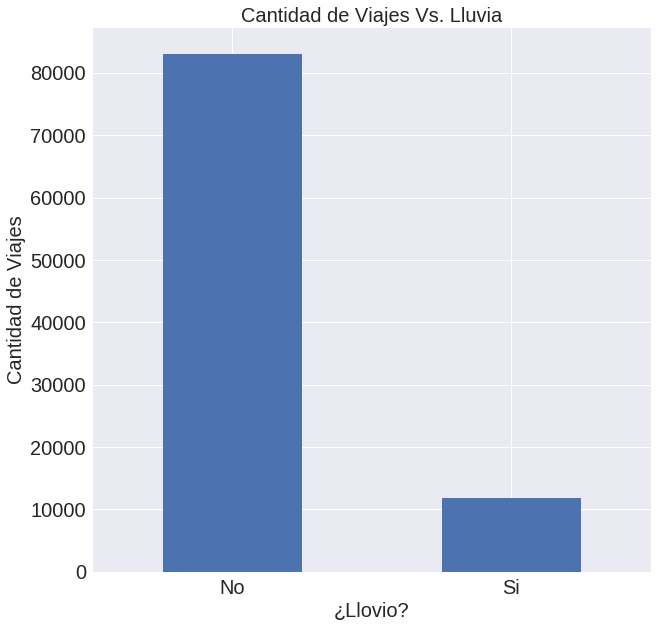

In [307]:
joined['lluvia'].value_counts().plot.bar(figsize=(10,10), fontsize=20, rot=0);
plt.xlabel('¿Llovio?', fontsize=20);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes Vs. Lluvia', fontsize=20);
plt.legend('');

Las observaciones que se hacen de este plot son:  
* Hay una diferencia de 70000 viajes a favor de los días en los que no llueve. Por ende, se puede decir que se viaja mucho más cuando no llueve.  
* Los 10000 viajes que se producen cuando llueve se pueden deber a que la intensidad de la lluvia es demasiado baja y, por lo tanto, los usuarios optan por seguir viajando.  

### 2.5.B) Duración promedio de los Viajes con Lluvia Vs. Duración promedio de los Viajes sin Lluvia

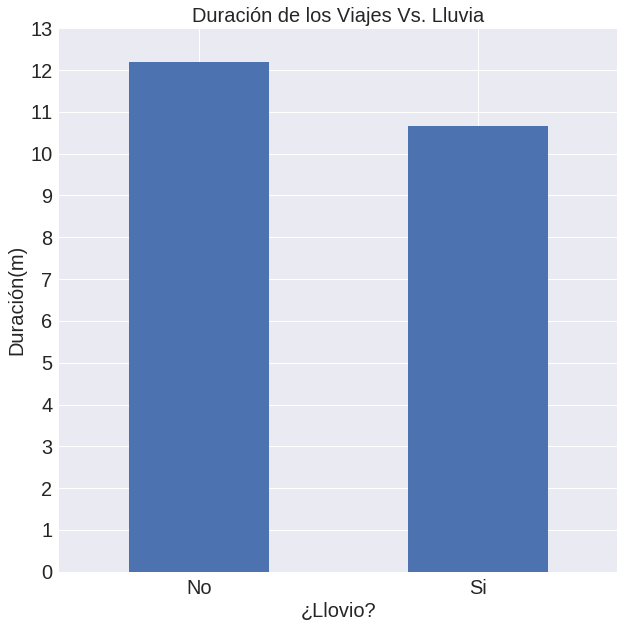

In [309]:
joined[['lluvia', 'duration_m']].groupby('lluvia').aggregate('mean').plot.bar(figsize=(10,10), fontsize=20, rot=0);
plt.yticks(range(0,14,1));
plt.xlabel('¿Llovio?', fontsize=20);
plt.ylabel('Duración(m)', fontsize=20)
plt.title('Duración de los Viajes Vs. Lluvia', fontsize=20);
plt.legend('');

Es interesante lo que se puede obtener de este plot. Si bien la diferencia de viajes entre los días con lluvia y los días sin lluvia es muy grande, la diferencia en duraciones promedio es muy pequeña, aproximadamente 1 minuto. Esto vuelve a indicar que los viajes que se realizan cuando llueve se producirían cuando la intensidad es baja.

### 2.5.C) Conclusión de Viajes y Lluvia

La conclusión de esta serie de plots es muy clara, se realizan más viajes cuando no llueve que cuando llueve. Pero las duraciones de los viajes que se realizan cuando llueve son cercanas a las duraciones de un viaje promedio cuando no llueve. Como se menciono previamente, una posible causa por la cual se presenta esto, es que los viajes se realizan cuando la lluvia tiene una intensidad baja.

# 3) Visualizaciones de Estaciones y Trayectos

Entónces la cantidad total de bicicletas utilizadas es de 700.

## 3.0) Lectura y limpieza de datos

In [2]:
stations = pd.read_csv('../data/station.csv', low_memory=False)

stations.rename(columns={'installation_date':'date',
                         'long'             :'lon'
                        }, inplace=True)

# Cambio el formato de las fechas
stations['date'] = pd.to_datetime(stations['date'])

In [3]:
trips = pd.read_csv('../data/trip.csv', low_memory=False)

#Eliminamos este dato ya que no sera relevante para estos analisis
del(trips['zip_code'])

trips.rename(columns={'start_date'        :'s_date' , 
                      'end_date'          :'e_date' , 
                      'start_station_name':'ss_name', 
                      'start_station_id'  :'ss_id'  , 
                      'end_station_name'  :'es_name', 
                      'end_station_id'    :'es_id'  , 
                      'subscription_type':'subs'
                     }, inplace=True)

# Cambio el formato de las fechas y tiempos de incio y fin de cada viaje
trips['s_date'] = pd.to_datetime(trips['s_date'], format='%m/%d/%Y %H:%M')
trips['e_date'] = pd.to_datetime(trips['e_date'], format='%m/%d/%Y %H:%M')

In [4]:
#Quitamos los viajes de duracion menor o igual a 3 minutos (180 segundos) y que de la misma estacion, 
#ya que pueden ser rutinas de mantenimiento o reparacion, etc
trips = trips[-((trips['duration'] <= 180) & (trips['ss_id'] == trips['es_id']))]
#trips = trips[-(trips['duration'] > 28800)]

#Se ordenan los viajes por id
trips = trips.sort_values(by='id')

Hay algunas estaciones que aparecen en trips, pero que no estan en stations.

In [6]:
#trips[trips['duration'] > 28800].shape
pd.to_datetime(trips_fechas['s_date'].dt.date)

(1886, 10)

## 3.1) Suscriptores vs Clientes

Quienes utilizan mas el servicio? Suscriptores o clientes comunes?

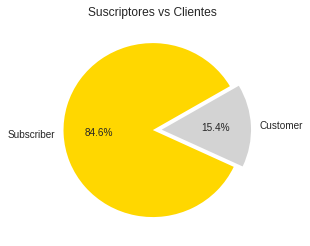

In [5]:
subs = trips.groupby('subs').count()[['id']]
lbls = subs.index.values
vals = subs.values

plt.figure(figsize=(4, 4))
plt.title('Suscriptores vs Clientes')
plt.pie(vals, explode=(0.1, 0), labels=lbls, colors=['lightgrey', 'gold'], autopct='%1.1f%%', startangle=-25)
plt.savefig('visu_subs_vs_cust.png')
plt.show()

Aqui se ve que la mayoria de los usuarios del servicio, estan suscriptos a este mismo. 

Esto puede indicar o refuerza la idea de que los usuarios del servicio, lo utilizan por necesidad y les es conveniente estar suscriptos.

## 3.2) 

In [6]:
trips_13_15 = trips
trips_2013 = trips['2014' > trips['s_date']].reset_index()
trips_2014 = trips[('2014' < trips['s_date']) & (trips['s_date'] < '2015')].reset_index()
trips_2015 = trips['2015' < trips['s_date']].reset_index()

viajes_por_anio = [trips_2013, trips_2014, trips_2015]
anios = ['2013', '2014', '2015']

#Calculamos la suma de bicicletas que partieron de las estaciones usadas en cada año
for i in range(len(viajes_por_anio)):
    viajes_por_anio[i]=viajes_por_anio[i].groupby('ss_name')['id'].count().sort_values(ascending=False)

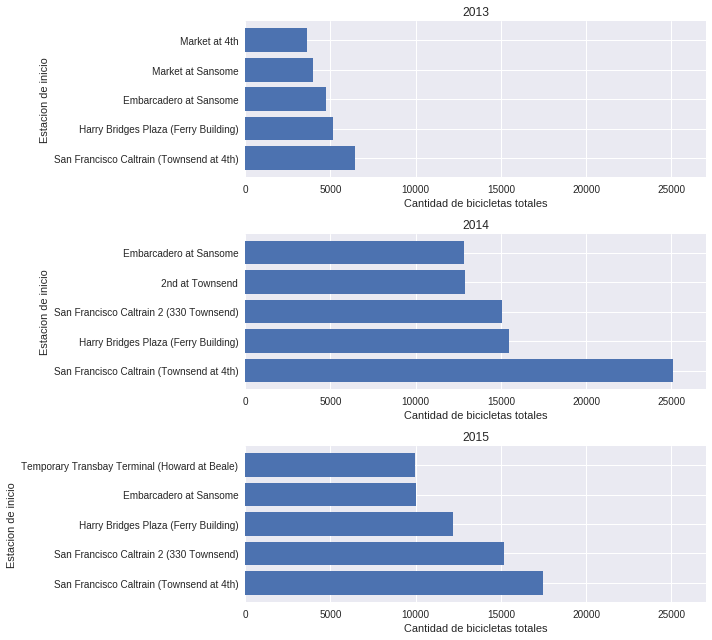

In [7]:
plt.figure(figsize=(10, 9))

for i in range(len(viajes_por_anio)):
    ax = plt.subplot(311 + i);
    ax.set_xlim([0, 27000])
    plt.title(anios[i]);
    plt.xlabel('Cantidad de bicicletas totales');
    plt.ylabel('Estacion de inicio');
    ax.barh([c for c in range(5)], [c for c in viajes_por_anio[i][:5].values], tick_label=[c for c in viajes_por_anio[i][:5].index.values])
    plt.savefig('viajes_' + anios[i] + '.png')

plt.tight_layout()

Hay que tener en cuenta que del año 2013 estan registrados los viajes entre Agosto y Diciembre, y del año 2015 de Enero a Agosto, por ese motivo se registran menos cantidad de viajes en cada estacion.

Una observacion interesante es que, para los 7 u 8 meses registrados en 2015, la utilizacion del servicio, si bien es menor a la del año 2014 (12 meses), es parecida. Esto indica que ubo un aumento en la cantidad de viajes entre esos años.

## 3.3) Visualizando con mapas

In [8]:
from math import pi as PI

def distancia_grados(dist):
    return (180 * dist) / (6371 * PI)

def distancia_km(angulo):
    return angulo * 6371 * PI / 180

def mean(a, b):
    return (a + b) / 2

def mmap(value, min_in, max_in, min_out, max_out):
    m = (max_out - min_out) / float(max_in - min_in)
    b = min_out - m * min_in
    return m * value + b

In [9]:
#Calculamos la cantidad de bicicletas por cada estacion
bicis_por_estacion = trips.groupby('ss_id').count()[['ss_name']].reset_index()

bicis_por_estacion.rename(columns={'ss_id':'id', 'ss_name':'count'}, inplace=True)

#Agregamos el nombre de la estacion, la ciudad en donde queda y sus coordenadas
estaciones = pd.merge(stations.drop(['date', 'dock_count'], 1), bicis_por_estacion, on='id')

### 3.3.1) Frecuencia de uso de Estaciones por ciudad

Lo que se quiere ver ahora es, como se distribuyen los viajes realizados entre las estaciones de cada ciudad.
(se utiliza la cantidad de bicicletas que parten de una estacion como medida de frecuencia de uso de una estacion)

In [10]:
#Separamos las estaciones por ciudad
sf = estaciones[estaciones['city'] == 'San Francisco'].reset_index(drop=True)
sj = estaciones[estaciones['city'] == 'San Jose'     ].reset_index(drop=True)
mv = estaciones[estaciones['city'] == 'Mountain View'].reset_index(drop=True)
pa = estaciones[estaciones['city'] == 'Palo Alto'    ].reset_index(drop=True)
rc = estaciones[estaciones['city'] == 'Redwood City' ].reset_index(drop=True)

ciudades = [sf, sj, mv, pa, rc, estaciones]
nombres = ['San Francisco', 'San Jose', 'Mountain View', 'Palo Alto', 'Redwood City', 'Bahia']
ciudades_cant_estaciones = []
ciudades_bicis = []

#Listas con latitudes y longitudes de cada ciudad
lats = []
lons = []

offsets = []

#Para cada ciudad, vemos su cantidad de estaciones y la cantidad total de bicicletas
for ciudad in ciudades:
    ciudades_cant_estaciones.append(ciudad.shape[0])
    ciudades_bicis.append(ciudad['count'].sum())
    #Para incluir a todas las estaciones (en la visualizacion), tomamos la media entre la coordenada maxima y minima
    lat_max, lat_min = ciudad['lat'].max(), ciudad['lat'].min()
    lon_max, lon_min = ciudad['lon'].max(), ciudad['lon'].min()
    lats.append(mean(lat_max, lat_min))
    lons.append(mean(lon_max, lon_min))
    offsets.append(max((lat_max - lat_min) * 0.6, (lon_max - lon_min) * 0.6))

#La cantidad de estaciones se va a utilizar para escalar a los tamaños de las estaciones en la visualizacion

In [11]:
#Seteamos algunas variables para los mapas
x_tam, y_tam = 500, 500 #1000, 1000

/home/mk/datos/benv/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mk/datos/benv/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/mk/datos/benv/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mk/datos/benv/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


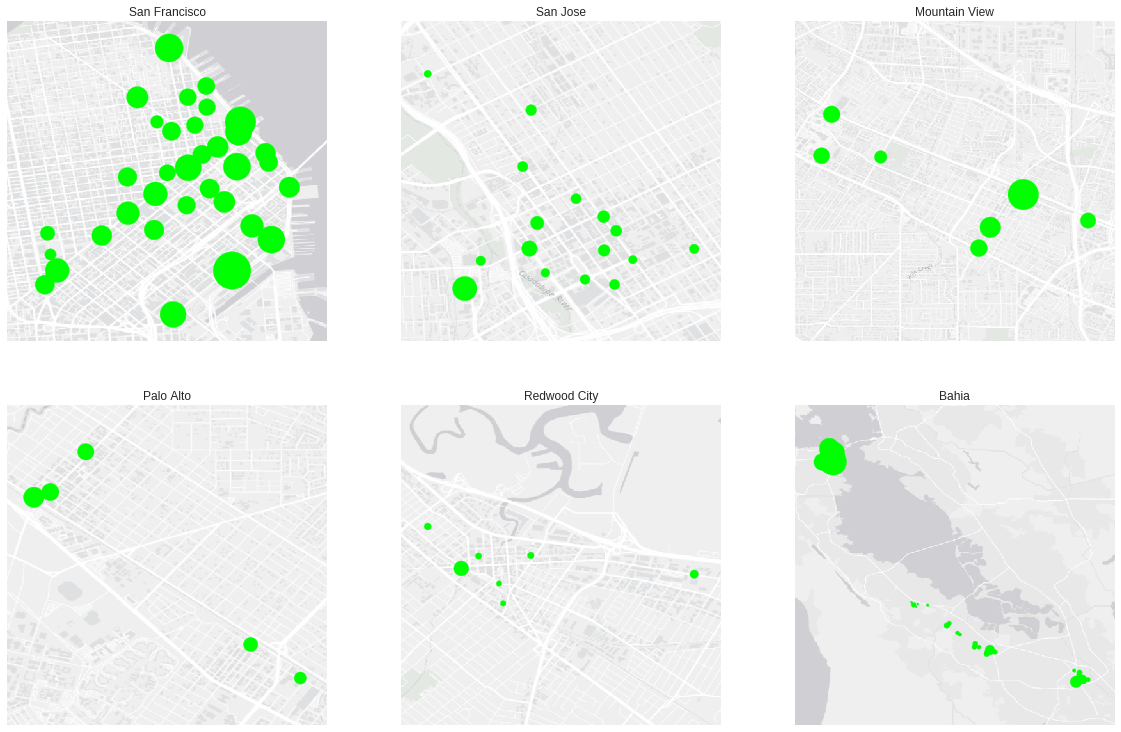

In [12]:
plt.figure(figsize=(20, 20))

for i in range(len(ciudades)):
    plt.subplot(331 + i);
    plt.title(nombres[i]);
    mapa=Basemap(projection='merc', resolution='i', epsg=4326, 
                 llcrnrlat=lats[i] - offsets[i], llcrnrlon=lons[i] - offsets[i], 
                 urcrnrlat=lats[i] + offsets[i], urcrnrlon=lons[i] + offsets[i])
    
    #Ploteamos las estaciones e indicamos frecuencia de uso segun la cantidad de viajes inciados desde esa estacion
    #Aqui se escalan los tamaños de las estaciones dependiendo de la ciudad que se muestre
    mapa.scatter(ciudades[i]['lon'].values, ciudades[i]['lat'].values, marker='o', c='#00ff00', 
                 s=ciudades[i]['count'].apply(lambda x:x/ciudades_cant_estaciones[i]));
    
    mapa.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=x_tam, ypixels=y_tam);
    plt.savefig(nombres[i] + '_map.png');

### 3.3.2) Comparando viajes por ciudad

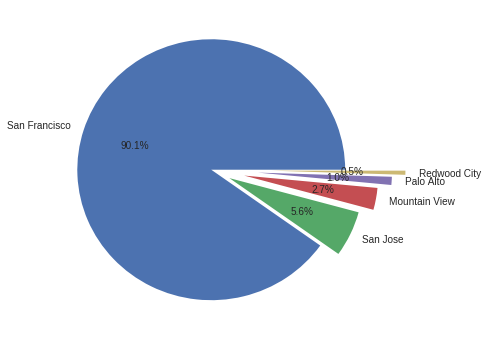

In [13]:
plt.figure(figsize=(6, 6))
plt.pie(ciudades_bicis[:-1:], labels=nombres[:-1:], autopct='%1.1f%%', explode=(0, .15, .25, .35, .45) )
plt.show()

Gran parte de los viajes parten de estaciones ubicadas en la ciudad de San Francisco

In [14]:
#Dataframe con los nombres de todas las estaciones y sus coordenadas
ss_location = stations[['name', 'lat', 'lon', 'city']]
ss_location.rename(columns={'name':'ss_name', 'lat':'s_lat', 'lon':'s_lon', 'city':'s_city'}, inplace=True)

es_location = stations[['name', 'lat', 'lon', 'city']]
es_location.rename(columns={'name':'es_name', 'lat':'e_lat', 'lon':'e_lon', 'city':'e_city'}, inplace=True)

#Estos dataframes seran combinados con los de trayectos por la columna que tengan en comun
#En este caso, se quiere obtener un dataframe con 2 estaciones (inicial y final) con sus coordenadas y viajes

/home/mk/datos/benv/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


### 3.3.3) Trayectos mas frecuentes

Lo que queremos lograr ahora es, ver cuales son los viajes entre estaciones mas utilizados.

Ademas de calcular los trayectos hay que juntar los que estan repetidos. Los trayectos con mas repeticiones seran considerados como los mas frecuentes.

In [15]:
trayectos_frec = trips[['id', 'ss_name', 'es_name']].groupby(['es_name', 'ss_name'], as_index=False).count()

trayectos_frec.rename(columns={'id':'count'}, inplace=True)

In [16]:
def reducir_trayectos(trayectos_frec):
    #El trayecto A -> B es el mismo que B -> A
    #Esta funcion junta las repeticiones de estos trayectos
    l = [] 
        #Lista con indice del dataframe del trayecto eliminado
    for i in range(len(trayectos_frec)):
            #Por cada trayecto
        if i not in l:
            #Si esta en el dataframe
            prim = trayectos_frec.loc[i]
                #Obtenemos el trayecto actual
            for j in range(i, len(trayectos_frec)):
                #Buscamos en lo que resta del dataframe
                if j not in l:
                    #Si el trayecto que queremos ver, esta en el dataframe
                    seg = trayectos_frec.loc[j] 
                        #Lo guardamos
                    if prim['ss_name'] == seg['es_name'] and prim['es_name'] == seg['ss_name']:
                        #Si coinciden los trayectos
                        trayectos_frec.loc[i]['count'] += trayectos_frec.loc[j]['count']
                            #Sumamos los trayectos
                            #Nosotros consideramos que los trayectos de A a B son iguales que los de B a A
                            #Pero en el dataframe no estan asi, por eso sumamos los viajes
                        trayectos_frec.drop(j, inplace=True)
                            #Quitamos al segundo trayecto del dataframe
                        l.append(j)
                            #Lo colocamos en la lista, para que no halla error luego
    return trayectos_frec

tf = reducir_trayectos(trayectos_frec)

# Añadimos al dataframe, las ubicaciones de cada estacion
tf = pd.merge(tf, ss_location, on='ss_name')
tf = pd.merge(tf, es_location, on='es_name')

/home/mk/datos/benv/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
#Este diccionario se va a contener, por ciudad:
#    . lista de tuplas del estilo ([lons], [lats], color) que tienen las coord de estaciones de un trayecto y su color
#    . lista de los trayectos de la ciudad
#respectivamente. Esto es para automatizar y tambien para colocar a todos los mapas en un subplot (de matplotlib)
viajes = {'San Francisco':[[], []], 
          'San Jose'     :[[], []], 
          'Redwood City' :[[], []], 
          'Mountain View':[[], []], 
          'Palo Alto'    :[[], []]
         }

for ciudad in viajes:
    #Filtramos los trayectos por ciudad
    #Aqui se quitan los trayectos con estaciones en distintas ciudades
    viajes[ciudad][1] = tf[(tf['s_city'] == ciudad) & \
                           (tf['e_city'] == ciudad)].drop(['s_city', 'e_city'], 1).reset_index(drop=True)
    
    #Calculamos la cantidad maxima de viajes por cada trayecto en cada ciudad
    #Esto es para luego asignar colores a trayectos con mas o menos frecuencia
    max_val = 0
    for indice in range(len(viajes[ciudad][1])):
        trayecto = viajes[ciudad][1].loc[indice]
        if trayecto['count'] > max_val:
            max_val = trayecto['count']
    
    #Colocamos longitud y latitud de un trayecto ademas de su frecuencia convertida a un numero en [0;255]
    for indice in range(len(viajes[ciudad][1])):
        trayecto = viajes[ciudad][1].loc[indice]
        color = int(mmap(trayecto['count'], 0, max_val, 0, 255))
        color = abs(255 - color)
        viajes[ciudad][0].append(([trayecto['s_lon'], trayecto['e_lon']], 
                                  [trayecto['s_lat'], trayecto['e_lat']], 
                                  color)
                                )
    #Ordenamos los viajes mas frecuentes al final, asi son mostrados por encima de los trayectos menos frecuentes
    viajes[ciudad][0].sort(key=lambda x:-x[2])

/home/mk/datos/benv/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mk/datos/benv/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


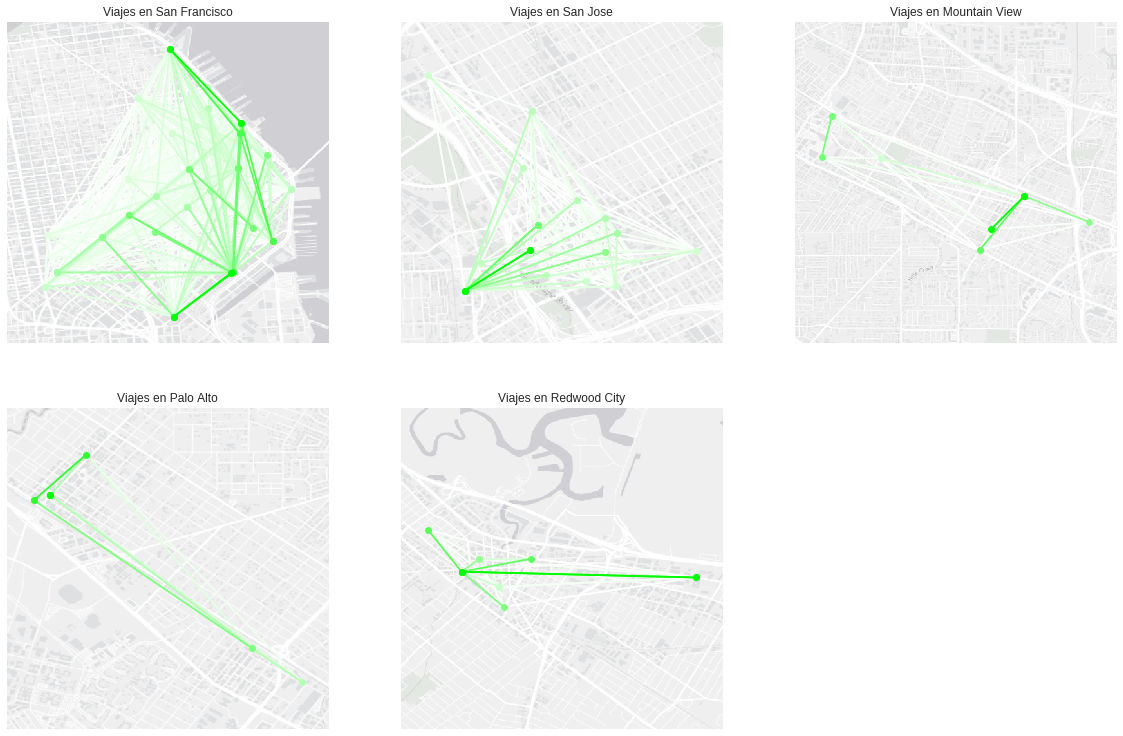

In [18]:
#Ahora visualizamos los trayectos por ciudad
plt.figure(figsize=(20, 13))

for i in range(len(ciudades)-1):
    plt.subplot(231 + i);
    plt.title('Viajes en ' + nombres[i]);
    mapa = Basemap(projection='merc', resolution='i', epsg=4326, 
                   llcrnrlat=lats[i] - offsets[i], llcrnrlon=lons[i] - offsets[i], 
                   urcrnrlat=lats[i] + offsets[i], urcrnrlon=lons[i] + offsets[i])
    
    for trayecto in viajes[nombres[i]][0]:
        #Convertimos el color a un formato RGBA valido
        color = trayecto[2]
        color = '#%02Xff%02X' % (color, color)
        #Ploteamos el trayecto
        mapa.plot(trayecto[0], trayecto[1], 'o-', color=color)

    mapa.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=x_tam, ypixels=y_tam, dpi=600);
    plt.savefig(nombres[i] + '_map_viajes.png');

### 3.3.4) Trayectos de toda la bahia

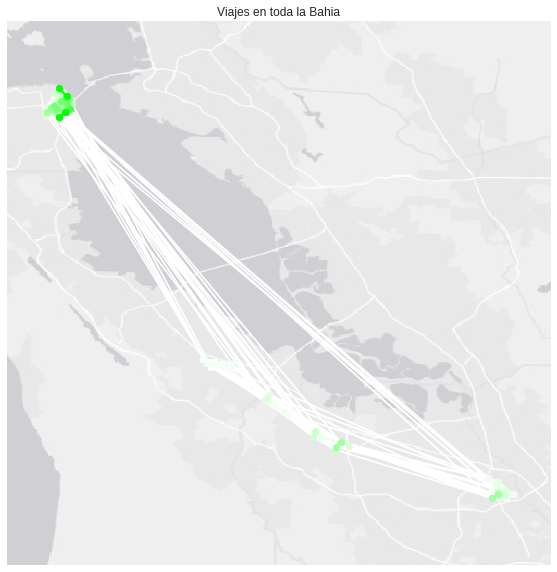

In [19]:
plt.figure(figsize=(10, 10))

offset = distancia_grados(35)
mapa = Basemap(projection='merc', resolution='i', epsg=4326, 
               llcrnrlat=lats[5] - offset, llcrnrlon=lons[5] - offset, 
               urcrnrlat=lats[5] + offset, urcrnrlon=lons[5] + offset )

max_val = tf['count'].max()
tf = tf.sort_values(by='count').reset_index(drop=True)

for indice in range(tf.shape[0]):
    trayecto = tf.loc[indice]
    #Mapeo de la frecuencia del trayecto al intervalo [0;255]
    color = int(mmap(trayecto['count'], 0, max_val, 0, 255))
    color = abs(255 - color)
    mapa.plot([trayecto['s_lon'], trayecto['e_lon']], 
              [trayecto['s_lat'], trayecto['e_lat']], 
              'o-', color='#%02Xff%02X' % (color, color))

mapa.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=x_tam, ypixels=y_tam);
plt.title('Viajes en toda la Bahia')
plt.show()

## 3.5) Cual es la cantidad total de bicicletas que se utilizó?

In [20]:
#Se cuentan los valores para cada id de bicicleta diferente
trips['bike_id'].value_counts().count()

700

El total de bicicletas diferentes utilizadas es de 700.

In [21]:
top_date = trips['s_date'].max()
antes = 0
print 'bicis  mesesAtras'
for i in range(top_date.month-1,-1,-1):
    date = str(top_date.year) + '-' + str(top_date.month - i)
    num = trips[trips['s_date'] > date]['bike_id'].value_counts().count()
    print num, '  ', i, '        ', str(antes-num)
    antes = num

bicis  mesesAtras
654    7          -654
652    6          2
648    5          4
639    4          9
634    3          5
629    2          5
618    1          11
593    0          25


### 3.5.1) Cantidad de bicicletas diferentes por mes

In [221]:
trips_fechas = trips[['s_date', 'bike_id']].reset_index(drop=True)
trips_fechas['s_date'] = pd.to_datetime(trips_fechas['s_date'].dt.date)

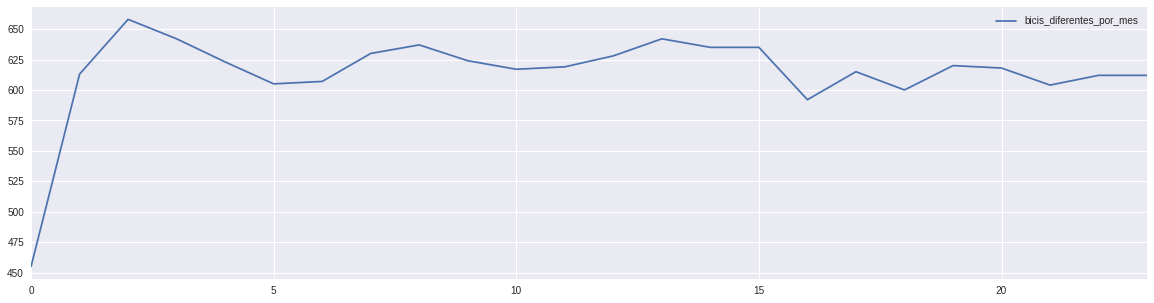

In [243]:
fecha_min, fecha_max = trips_fechas['s_date'].min(), trips_fechas['s_date'].max()
bicis_mes = []
import datetime

rango_de_fechas = (pd.date_range(fecha_min, fecha_max, freq='M').date)

for i in range(len(rango_de_fechas)-1):
    bicis_mes.append(trips_fechas[(trips_fechas['s_date']>=rango_de_fechas[i].strftime('%Y-%m'))&\
                                  (trips_fechas['s_date']<rango_de_fechas[i+1].strftime('%Y-%m'))\
                                 ]['bike_id'].value_counts().count())

df = pd.DataFrame({'bicis_diferentes_por_mes':bicis_mes, 'mes':rango_de_fechas[:-1:]})
df.plot.line(figsize=(20, 5));